In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)
import scipy.stats as stats
sns.set(palette='husl', context = 'talk', style='white', font_scale=1)

import os
import scikit_posthocs as sp
from pybedtools import BedTool
import pybedtools
from upsetplot import plot, from_indicators

In [2]:
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level


# Wynton
#BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
#DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data 
#RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results

#SRC_PATH = os.path.join(BASE_PATH, "src")  # where any packages needed to run analyses live. I haven't started structuring things this way yet. 

#COMP_PATH = os.path.join(DATA_PATH,"pairwise/hsmrca")
#COMP_PATH = os.path.join(DATA_PATH,"pairwise/reference")


# Local

DATA_PATH = os.path.join(BASE_PATH, "../../../dowloads/")  # where I dump new data
COMP_PATH = os.path.join(DATA_PATH,"1KGvsHSMRCA")

In [3]:
DATA_PATH

'/Users/egilbertson/Box Sync/UCSF/CapraLab/3DGenome/bin/3Dbin/activeNotebooks/../../../dowloads/'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:

anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % DATA_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
windows_to_keep = anc_div.index

In [6]:
windows_to_keep.to_frame(index=False).to_csv('%s/intermediates/windows_to_keep.csv' % DATA_PATH)

# Genome Wide 3D

In [7]:
def population_order(df, metric):
    sup_order = df.groupby(by=["super_pop"])[metric].mean().sort_values().index
    sub_order = df.groupby(by=["sub_pop"])[metric].mean().sort_values().index
    
    sup_mapping = pd.DataFrame({
    'super': sup_order,
    })
    sup_mapping = sup_mapping.reset_index().set_index('super')

    sub_mapping = pd.DataFrame({
        'sub': sub_order,
    })
    sub_mapping = sub_mapping.reset_index().set_index('sub')
    
    df['super_rank'] = df['super_pop'].map(sup_mapping['index'])
    df['sub_rank'] = df['sub_pop'].map(sub_mapping['index'])
    
    my_order = df.sort_values(['super_rank','sub_rank'])
    
    my_order = my_order['sub_pop'].drop_duplicates().values
    
    amr_pal = sns.diverging_palette(50,230, s=82, l=58, n=10)[-4:]
    eur_pal = sns.diverging_palette(50,230, s=82, l=58, n=15)[:5]
    afr_pal = sns.diverging_palette(50,369, s=82, l=58, n=17)[-7:]
    sas_pal = sns.diverging_palette(190,369, s=82, l=58, n=12)[:5]
    eas_pal = sns.diverging_palette(110,105, s=75, l=65, n=10)[:5]
    
    my_pal = eur_pal + amr_pal + eas_pal + sas_pal + afr_pal

    sub_order = my_order
    sub_pal = my_pal

    sup_pal = [eur_pal[0], amr_pal[3], eas_pal[0], sas_pal[0], afr_pal[6]]

    return sub_order, sub_pal, sup_order, sup_pal

In [8]:
def plot_pop_metric(df,my_order, my_pal, metric, ytitle):
    plt.figure(figsize=(100,30))
    sns.stripplot(x='sub_pop', y=metric, data=df, dodge=False,s=20, 
                  palette=my_pal, 
                  order = my_order)
    plt.xlabel('\n1KG Population', fontsize=100)
    plt.ylabel(ytitle, fontsize=100)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=100)
    plt.tick_params(axis='both', which='major', labelsize=80)
    #plt.savefig('fig2.svg', format='svg')
    
    return

In [7]:
anc = pd.read_table('%s/comp_tables/anc_genomewide_averages.csv' % DATA_PATH,
                    sep=',', index_col=0)
drops = anc[np.isnan(anc.genome_avg_mse)].index
anc = anc.drop(index=drops)
anc['divergence'] = 1-anc.genome_avg_spearman

In [10]:
anc

ancestor  genome_avg_mse  genome_avg_spearman  \
1KG                                                                             
AFR_ACB_female_HG01880  hsmrca_ancestral        0.000654             0.995720   
AFR_ACB_female_HG01883  hsmrca_ancestral        0.000688             0.995387   
AFR_ACB_female_HG01886  hsmrca_ancestral        0.000680             0.995517   
AFR_ACB_female_HG01889  hsmrca_ancestral        0.000709             0.995272   
AFR_ACB_female_HG01894  hsmrca_ancestral        0.000683             0.995589   
...                                  ...             ...                  ...   
SAS_STU_male_HG04039    hsmrca_ancestral        0.000642             0.995748   
SAS_STU_male_HG04100    hsmrca_ancestral        0.000664             0.995672   
SAS_STU_male_HG04107    hsmrca_ancestral        0.000671             0.995665   
SAS_STU_male_HG04210    hsmrca_ancestral        0.000663             0.995597   
SAS_STU_male_HG04229    hsmrca_ancestral        0.000669             0.995534   

                       super_pop sub_pop     sex       id  divergence  
1KG                                                                    
AFR_ACB_female_HG01880       AFR     ACB  female  HG01880    0.004280  
AFR_ACB_female_HG01883       AFR     ACB  female  HG01883    0.004613  
AFR_ACB_female_HG01886       AFR     ACB  female  HG01886    0.004483  
AFR_ACB_female_HG01889       AFR     ACB  female  HG01889    0.004728  
AFR_ACB_female_HG01894       AFR     ACB  female  HG01894    0.004411  
...                          ...     ...     ...      ...         ...  
SAS_STU_male_HG04039         SAS     STU    male  HG04039    0.004252  
SAS_STU_male_HG04100         SAS     STU    male  HG04100    0.004328  
SAS_STU_male_HG04107         SAS     STU    male  HG04107    0.004335  
SAS_STU_male_HG04210         SAS     STU    male  HG04210    0.004403  
SAS_STU_male_HG04229         SAS     STU    male  HG04229    0.004466  

[2457 rows x 8 columns]

In [9]:
anc_div

AFR                                          \
                           ACB                                           
                        female                                           
                       HG01880   HG01883   HG01886   HG01889   HG01894   
chr   windowStartPos                                                     
chr1  1048576         0.000982  0.001551  0.001609  0.001618  0.003944   
      1572864         0.001445  0.001657  0.001909  0.001959  0.004272   
      3145728         0.001283  0.000683  0.002624  0.002458  0.002041   
      3670016         0.005119  0.004878  0.001901  0.002729  0.004874   
      4194304         0.008681  0.007497  0.004502  0.004731  0.011335   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.007145  0.001892  0.002877  0.008396  0.004389   
      47185920        0.027227  0.006835  0.003085  0.035391  0.003696   
      47710208        0.039303  0.045497  0.065454  0.123312  0.028221   
      48234496        0.183482  0.189969  0.241011  0.325763  0.195117   
      48758784        0.005628  0.014172  0.002837  0.015048  0.012794   

                                                                        ...  \
                                                                        ...   
                                                                        ...   
                       HG01896   HG01915   HG01956   HG01958   HG01985  ...   
chr   windowStartPos                                                    ...   
chr1  1048576         0.002145  0.001217  0.000658  0.002693  0.002143  ...   
      1572864         0.002573  0.001838  0.002096  0.006768  0.002917  ...   
      3145728         0.002661  0.000521  0.002490  0.003151  0.002294  ...   
      3670016         0.001535  0.004503  0.004706  0.004062  0.006236  ...   
      4194304         0.006836  0.007988  0.010622  0.007037  0.014604  ...   
...                        ...       ...       ...       ...       ...  ...   
chr22 46661632        0.002007  0.003275  0.006965  0.002858  0.006226  ...   
      47185920        0.007332  0.002898  0.017533  0.005524  0.002682  ...   
      47710208        0.040250  0.046180  0.030846  0.038820  0.033115  ...   
      48234496        0.174392  0.179873  0.198540  0.168733  0.161755  ...   
      48758784        0.003188  0.005283  0.012890  0.003300  0.013330  ...   

                           SAS                                          \
                           STU                                           
                          male                                           
                       HG03998   HG03999   HG04003   HG04006   HG04033   
chr   windowStartPos                                                     
chr1  1048576         0.000387  0.000713  0.000919  0.000718  0.000841   
      1572864         0.001048  0.000703  0.001067  0.000496  0.001208   
      3145728         0.003141  0.004537  0.000520  0.000528  0.001665   
      3670016         0.005861  0.006603  0.004933  0.004321  0.004428   
      4194304         0.009956  0.011672  0.013004  0.005318  0.008290   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.003228  0.002667  0.003284  0.002222  0.001290   
      47185920        0.007095  0.003824  0.004329  0.003580  0.003119   
      47710208        0.037299  0.045959  0.036592  0.034629  0.043876   
      48234496        0.166427  0.189953  0.157409  0.160880  0.186454   
      48758784        0.005060  0.005483  0.003194  0.004617  0.005598   

                                                                        
                                                                        
                                                                        
                       HG04039   HG04100   HG04107   HG04210   HG04229  
chr   windowStartPos                                                    
chr1  1048576         0.000

In [10]:
sub_order, sub_pal, sup_order, sup_pal =population_order(anc, 'divergence')

In [11]:
sub_pal

[(0.706670293609049, 0.5093997303734449, 0.22414913576687667),
 (0.7412716621541051, 0.5707304545629114, 0.3249249989963094),
 (0.7758730306991612, 0.6320611787523777, 0.42570086222574205),
 (0.8104743992442174, 0.6933919029418442, 0.5264767254551748),
 (0.8479554606792538, 0.7598268660042837, 0.6356396424060673),
 (0.7138514591292806, 0.8262184223783144, 0.8775670924419225),
 (0.5552584329455093, 0.7420118141043546, 0.8257624345335782),
 (0.40471949211451236, 0.6620816057871005, 0.7765886560939287),
 (0.2541805512835154, 0.5821513974698465, 0.7274148776542794),
 (0.5061679352128585, 0.6675954483699535, 0.3024282922555064),
 (0.5994839972981465, 0.7300087731148024, 0.4368319146885214),
 (0.6928000593834346, 0.7924220978596512, 0.5712355371215364),
 (0.7911086870113715, 0.8581746399649424, 0.7128299783607821),
 (0.8844247490966596, 0.9205879647097912, 0.8472336007937971),
 (0.2416826875486161, 0.5991756083655165, 0.5923648937866773),
 (0.36394772525165214, 0.6628215022818902, 0.65704911

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


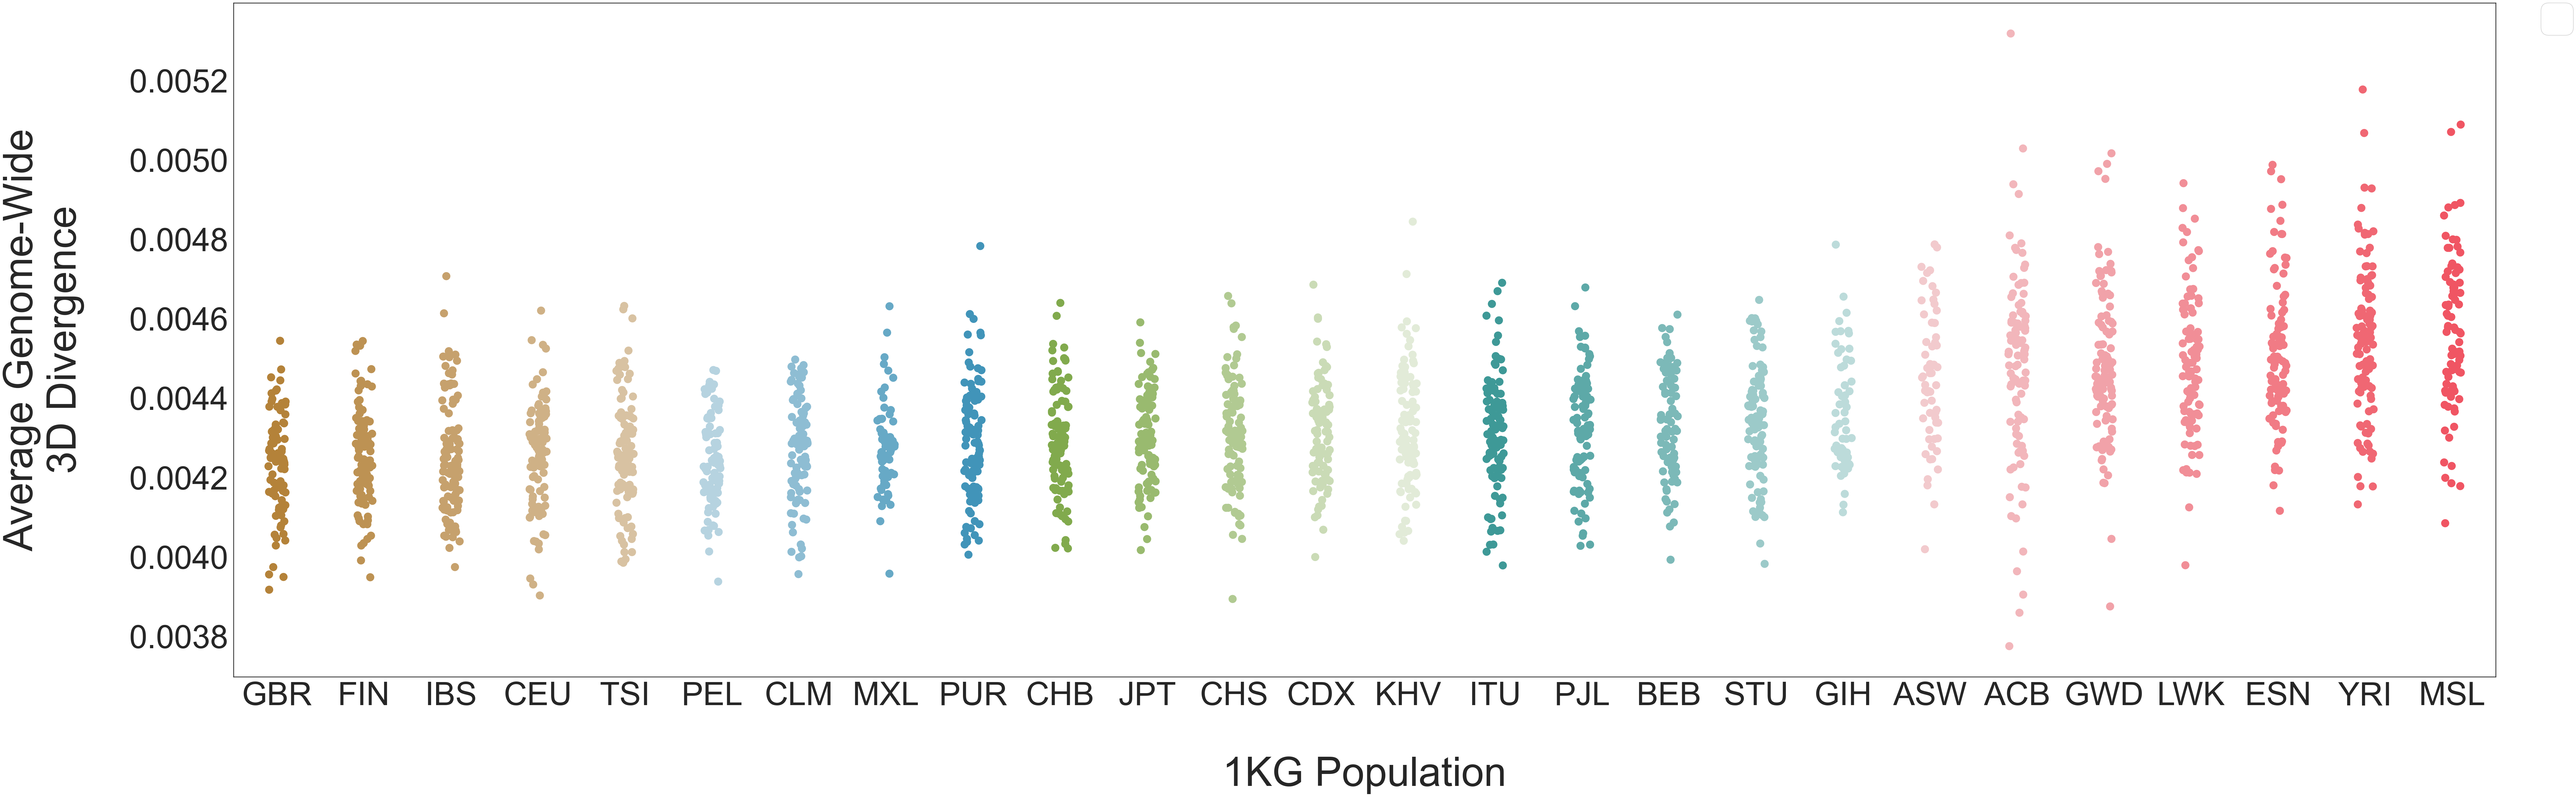

In [ ]:
plot_pop_metric(anc, sub_order, sub_pal, 'divergence','Average Genome-Wide\n3D Divergence\n')

In [ ]:
anc

ancestor  genome_avg_mse  genome_avg_spearman  \
1KG                                                                             
AFR_ACB_female_HG01880  hsmrca_ancestral        0.000654             0.995720   
AFR_ACB_female_HG01883  hsmrca_ancestral        0.000688             0.995387   
AFR_ACB_female_HG01886  hsmrca_ancestral        0.000680             0.995517   
AFR_ACB_female_HG01889  hsmrca_ancestral        0.000709             0.995272   
AFR_ACB_female_HG01894  hsmrca_ancestral        0.000683             0.995589   
...                                  ...             ...                  ...   
SAS_STU_male_HG04039    hsmrca_ancestral        0.000642             0.995748   
SAS_STU_male_HG04100    hsmrca_ancestral        0.000664             0.995672   
SAS_STU_male_HG04107    hsmrca_ancestral        0.000671             0.995665   
SAS_STU_male_HG04210    hsmrca_ancestral        0.000663             0.995597   
SAS_STU_male_HG04229    hsmrca_ancestral        0.000669             0.995534   

                       super_pop sub_pop     sex       id  divergence  \
1KG                                                                     
AFR_ACB_female_HG01880       AFR     ACB  female  HG01880    0.004280   
AFR_ACB_female_HG01883       AFR     ACB  female  HG01883    0.004613   
AFR_ACB_female_HG01886       AFR     ACB  female  HG01886    0.004483   
AFR_ACB_female_HG01889       AFR     ACB  female  HG01889    0.004728   
AFR_ACB_female_HG01894       AFR     ACB  female  HG01894    0.004411   
...                          ...     ...     ...      ...         ...   
SAS_STU_male_HG04039         SAS     STU    male  HG04039    0.004252   
SAS_STU_male_HG04100         SAS     STU    male  HG04100    0.004328   
SAS_STU_male_HG04107         SAS     STU    male  HG04107    0.004335   
SAS_STU_male_HG04210         SAS     STU    male  HG04210    0.004403   
SAS_STU_male_HG04229         SAS     STU    male  HG04229    0.004466   

                        super_rank  sub_rank  
1KG                                           
AFR_ACB_female_HG01880           4        20  
AFR_ACB_female_HG01883           4        20  
AFR_ACB_female_HG01886           4        20  
AFR_ACB_female_HG01889           4        20  
AFR_ACB_female_HG01894           4        20  
...                            ...       ...  
SAS_STU_male_HG04039             3        17  
SAS_STU_male_HG04100             3        17  
SAS_STU_male_HG04107             3        17  
SAS_STU_male_HG04210             3        17  
SAS_STU_male_HG04229             3        17  

[2457 rows x 10 columns]

In [ ]:
anc[anc['sub_pop']=='PUR'].divergence.idxmax()

'AMR_PUR_female_HG01108'

# Sequence

### Import Sequence Data

In [12]:
list_file = os.path.join(DATA_PATH, "reference/lists/listOfPairwiseComps_hsmrca.txt")
base = 'hsmrca_ancestral'
#COMP_PATH = os.path.join(DATA_PATH,"pairwise/sequence/1KGvsHSMRCA")

base_df = anc[['ancestor']]
comp_dict_seq = {}
print('first for')
for row in base_df.index:
    ind = str(base_df.loc[row].name)
    filename = 'SeqComps_%s_vs_%s.txt' % (ind,base)
    if os.path.exists('%s/%s' % (COMP_PATH,filename)):
        try:
            df = pd.read_table('%s/%s' % (COMP_PATH,filename))
            df = df[df.chrm != 'chrX']
            comp_dict_seq[ind] = df
        except:
            print('broken')
            continue     
print('done')

indivs = list(comp_dict_seq.keys())
### Window by window
seq_id = pd.DataFrame(index = windows_to_keep, columns = indivs)

### Genome wide averages        
base_df['seq_id']=''
print('second for')
for ind in comp_dict_seq.keys():
    df = comp_dict_seq[ind]
    df = df.set_index(['chrm','start_loc'])
    try:
        df = df.loc[windows_to_keep]
        avg_seq_id =float(np.mean(df['seqComp_raw'].astype('float')))

        base_df.seq_id.loc[ind]=avg_seq_id

        seq_id[ind]=df['seqComp_raw'].astype(float)
    except:
        print('missing data for individual: %s' % ind)
print('done')  



base_df['temp'] = base_df.index
new = base_df.temp.str.split("_", expand = True)
base_df['super_pop'] = new[0]
base_df['sub_pop'] = new[1]
base_df['sex'] = new[2]
base_df['id'] = new[3]

genome_wide = base_df.drop(columns=['temp'])
genome_wide = genome_wide[genome_wide.seq_id != '']
genome_wide.seq_id = genome_wide.seq_id.astype('float')

seq_id.columns = seq_id.columns.str.split('_', expand=True)

first for
done
second for
missing data for individual: SAS_ITU_male_HG04060
done


In [13]:
genome_wide['seq_diff'] = 1-genome_wide['seq_id']

### Correlate Sequence and 3D

In [14]:
anc

ancestor  genome_avg_mse  genome_avg_spearman  \
1KG                                                                             
AFR_ACB_female_HG01880  hsmrca_ancestral        0.000654             0.995720   
AFR_ACB_female_HG01883  hsmrca_ancestral        0.000688             0.995387   
AFR_ACB_female_HG01886  hsmrca_ancestral        0.000680             0.995517   
AFR_ACB_female_HG01889  hsmrca_ancestral        0.000709             0.995272   
AFR_ACB_female_HG01894  hsmrca_ancestral        0.000683             0.995589   
...                                  ...             ...                  ...   
SAS_STU_male_HG04039    hsmrca_ancestral        0.000642             0.995748   
SAS_STU_male_HG04100    hsmrca_ancestral        0.000664             0.995672   
SAS_STU_male_HG04107    hsmrca_ancestral        0.000671             0.995665   
SAS_STU_male_HG04210    hsmrca_ancestral        0.000663             0.995597   
SAS_STU_male_HG04229    hsmrca_ancestral        0.000669             0.995534   

                       super_pop sub_pop     sex       id  divergence  \
1KG                                                                     
AFR_ACB_female_HG01880       AFR     ACB  female  HG01880    0.004280   
AFR_ACB_female_HG01883       AFR     ACB  female  HG01883    0.004613   
AFR_ACB_female_HG01886       AFR     ACB  female  HG01886    0.004483   
AFR_ACB_female_HG01889       AFR     ACB  female  HG01889    0.004728   
AFR_ACB_female_HG01894       AFR     ACB  female  HG01894    0.004411   
...                          ...     ...     ...      ...         ...   
SAS_STU_male_HG04039         SAS     STU    male  HG04039    0.004252   
SAS_STU_male_HG04100         SAS     STU    male  HG04100    0.004328   
SAS_STU_male_HG04107         SAS     STU    male  HG04107    0.004335   
SAS_STU_male_HG04210         SAS     STU    male  HG04210    0.004403   
SAS_STU_male_HG04229         SAS     STU    male  HG04229    0.004466   

                        super_rank  sub_rank  
1KG                                           
AFR_ACB_female_HG01880           4        20  
AFR_ACB_female_HG01883           4        20  
AFR_ACB_female_HG01886           4        20  
AFR_ACB_female_HG01889           4        20  
AFR_ACB_female_HG01894           4        20  
...                            ...       ...  
SAS_STU_male_HG04039             3        17  
SAS_STU_male_HG04100             3        17  
SAS_STU_male_HG04107             3        17  
SAS_STU_male_HG04210             3        17  
SAS_STU_male_HG04229             3        17  

[2457 rows x 10 columns]

In [15]:
genome_wide_both = genome_wide.merge(anc[['divergence', 'super_rank','sub_rank']], how='inner', left_index=True, right_index=True).drop(columns=['seq_id'])

In [16]:
sup_pal

[(0.706670293609049, 0.5093997303734449, 0.22414913576687667),
 (0.2541805512835154, 0.5821513974698465, 0.7274148776542794),
 (0.5061679352128585, 0.6675954483699535, 0.3024282922555064),
 (0.2416826875486161, 0.5991756083655165, 0.5923648937866773),
 (0.9420739404731048, 0.33350289719169146, 0.38668266469046336)]

In [17]:
genome_wide_both

ancestor super_pop sub_pop     sex       id  \
1KG                                                                           
AFR_ACB_female_HG01880  hsmrca_ancestral       AFR     ACB  female  HG01880   
AFR_ACB_female_HG01883  hsmrca_ancestral       AFR     ACB  female  HG01883   
AFR_ACB_female_HG01886  hsmrca_ancestral       AFR     ACB  female  HG01886   
AFR_ACB_female_HG01889  hsmrca_ancestral       AFR     ACB  female  HG01889   
AFR_ACB_female_HG01894  hsmrca_ancestral       AFR     ACB  female  HG01894   
...                                  ...       ...     ...     ...      ...   
SAS_STU_male_HG04039    hsmrca_ancestral       SAS     STU    male  HG04039   
SAS_STU_male_HG04100    hsmrca_ancestral       SAS     STU    male  HG04100   
SAS_STU_male_HG04107    hsmrca_ancestral       SAS     STU    male  HG04107   
SAS_STU_male_HG04210    hsmrca_ancestral       SAS     STU    male  HG04210   
SAS_STU_male_HG04229    hsmrca_ancestral       SAS     STU    male  HG04229   

                        seq_diff  divergence  super_rank  sub_rank  
1KG                                                                 
AFR_ACB_female_HG01880  0.001591    0.004280           4        20  
AFR_ACB_female_HG01883  0.001614    0.004613           4        20  
AFR_ACB_female_HG01886  0.001623    0.004483           4        20  
AFR_ACB_female_HG01889  0.001628    0.004728           4        20  
AFR_ACB_female_HG01894  0.001616    0.004411           4        20  
...                          ...         ...         ...       ...  
SAS_STU_male_HG04039    0.001522    0.004252           3        17  
SAS_STU_male_HG04100    0.001527    0.004328           3        17  
SAS_STU_male_HG04107    0.001521    0.004335           3        17  
SAS_STU_male_HG04210    0.001527    0.004403           3        17  
SAS_STU_male_HG04229    0.001527    0.004466           3        17  

[2456 rows x 9 columns]

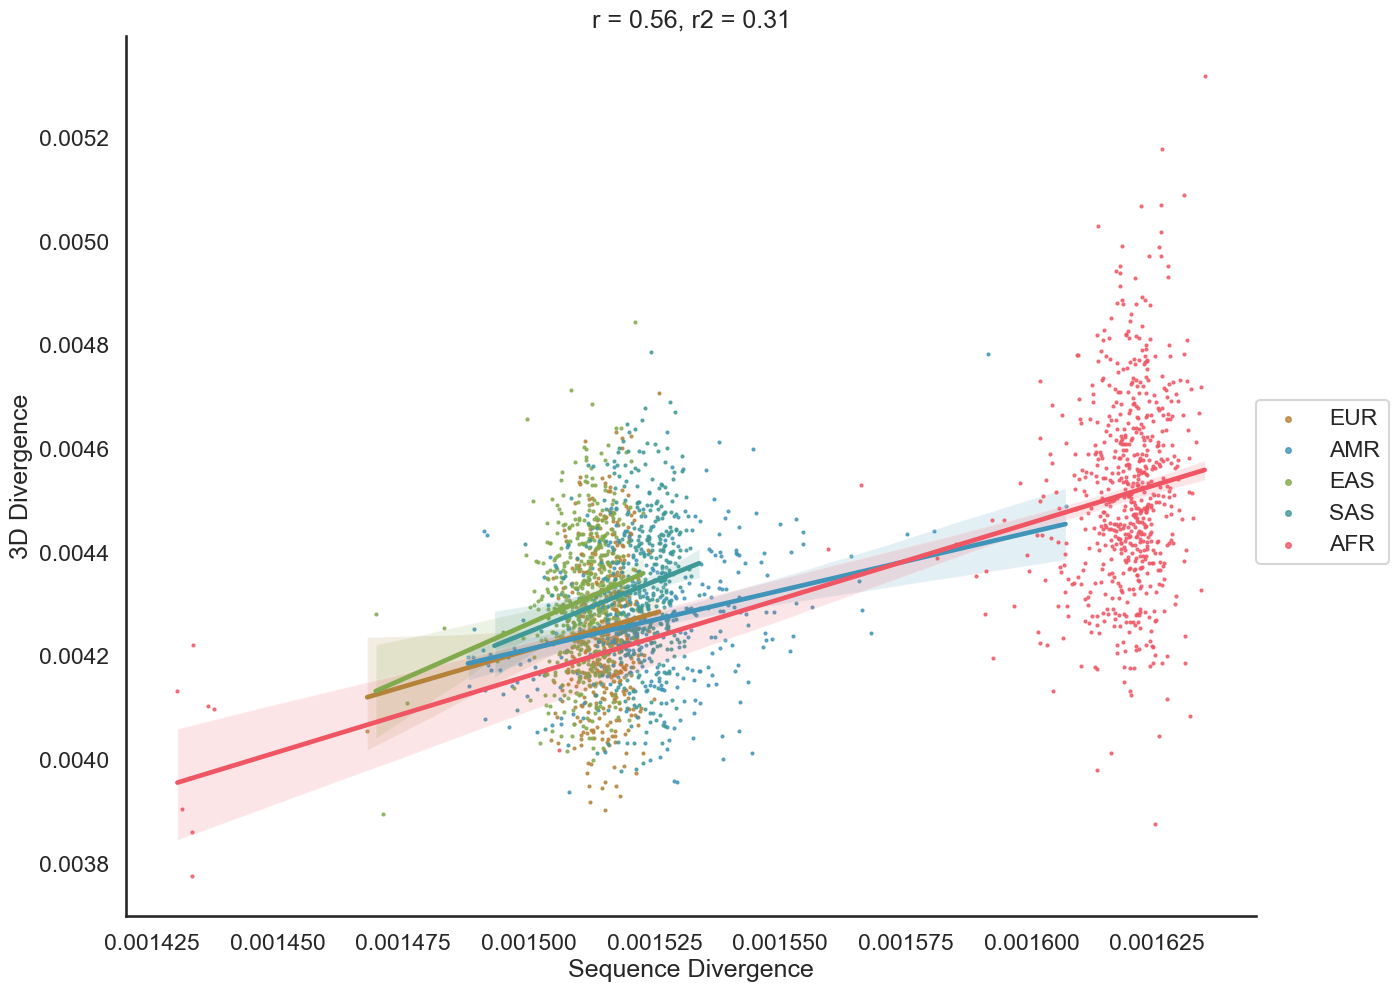

In [22]:

sns.lmplot(x='seq_diff',y='divergence', hue='super_pop', data=genome_wide_both,scatter_kws={'s':4},aspect=1.3,palette = sup_pal,  
hue_order = sup_order, legend=False, height=10)

slope, intercept, r, p, se = stats.linregress(genome_wide_both['seq_diff'].values, genome_wide_both['divergence'].values)
plt.title('r = %0.2f, r2 = %0.2f' % (r, r**2))

plt.xlabel('Sequence Divergence')
plt.ylabel('3D Divergence')
plt.legend(markerscale=2, loc=(1,.4))


### Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


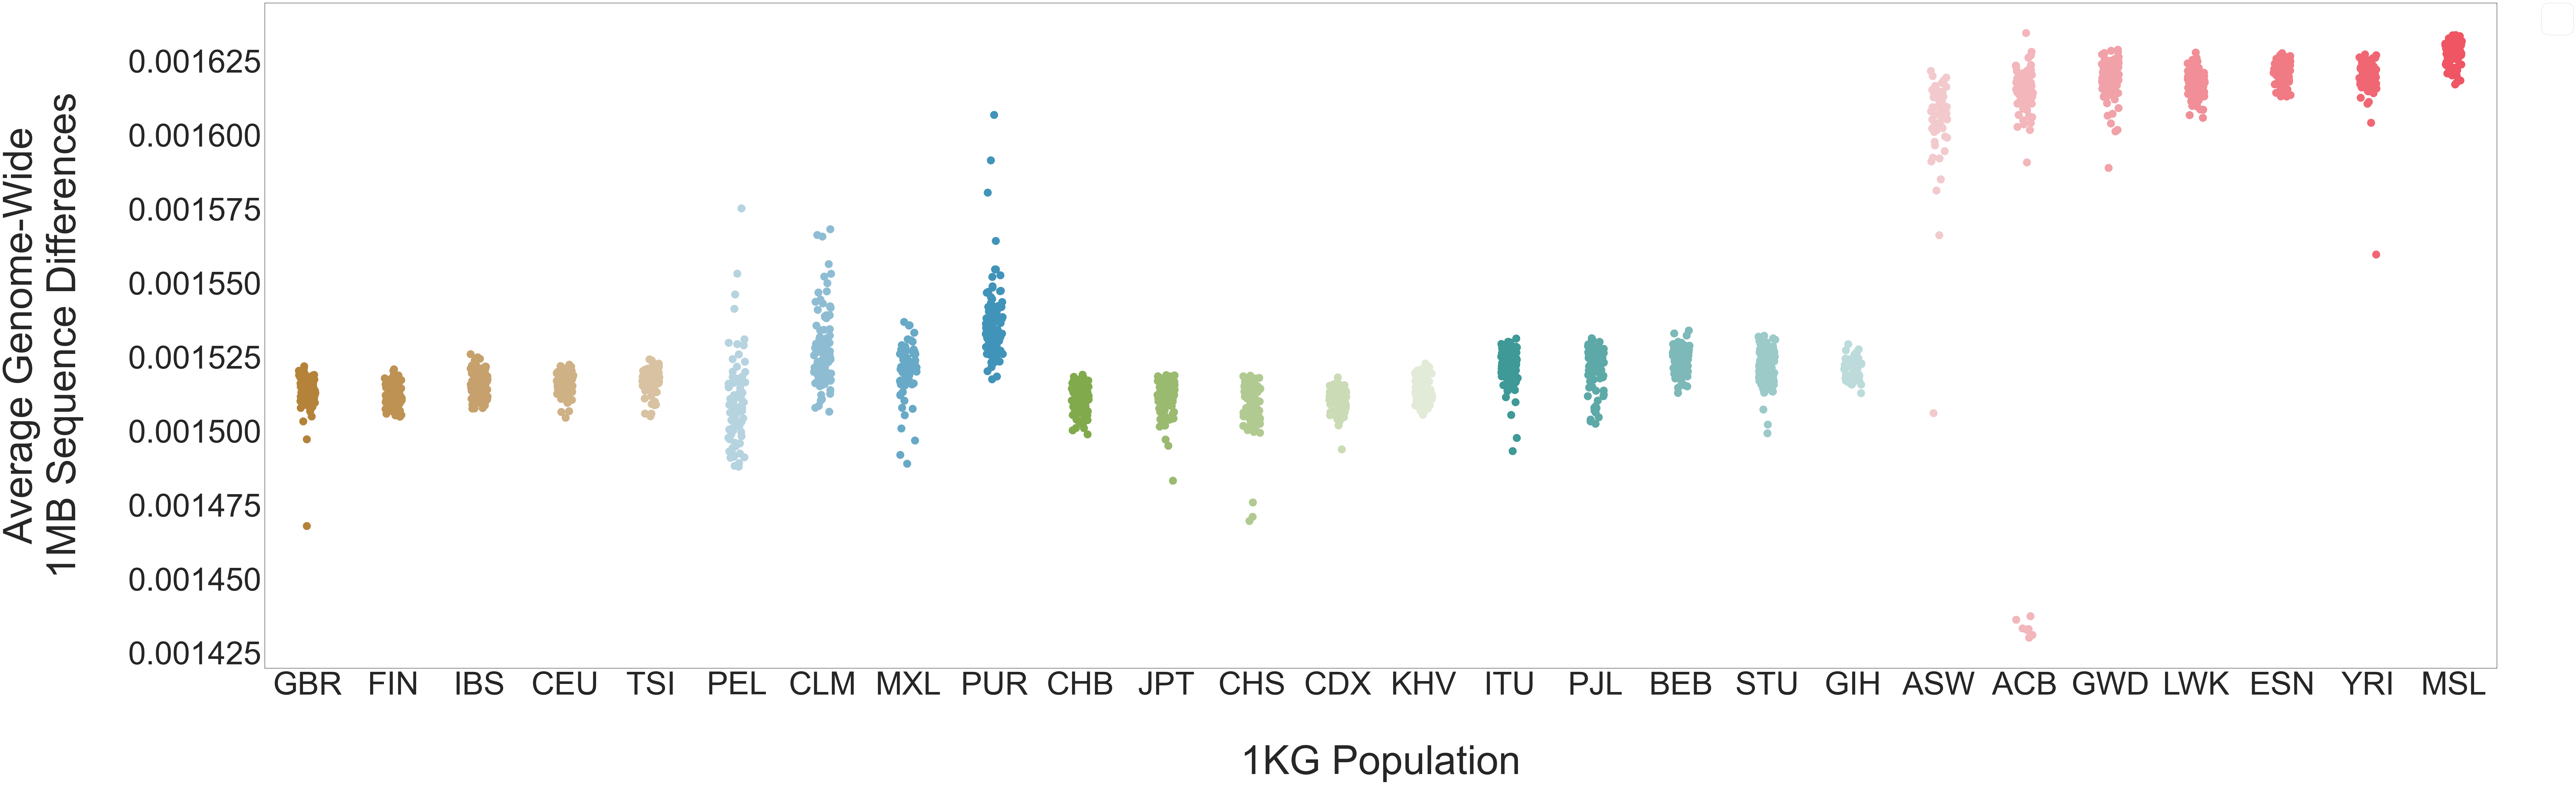

In [198]:
plot_pop_metric(genome_wide, sub_order, sub_pal, 'seq_diff','Average Genome-Wide\n1MB Sequence Differences\n')

# Windows

## chrm plots

In [401]:
anc_div

AFR                                          \
                           ACB                                           
                        female                                           
                       HG01880   HG01883   HG01886   HG01889   HG01894   
chr   windowStartPos                                                     
chr1  1048576         0.000982  0.001551  0.001609  0.001618  0.003944   
      1572864         0.001445  0.001657  0.001909  0.001959  0.004272   
      3145728         0.001283  0.000683  0.002624  0.002458  0.002041   
      3670016         0.005119  0.004878  0.001901  0.002729  0.004874   
      4194304         0.008681  0.007497  0.004502  0.004731  0.011335   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.007145  0.001892  0.002877  0.008396  0.004389   
      47185920        0.027227  0.006835  0.003085  0.035391  0.003696   
      47710208        0.039303  0.045497  0.065454  0.123312  0.028221   
      48234496        0.183482  0.189969  0.241011  0.325763  0.195117   
      48758784        0.005628  0.014172  0.002837  0.015048  0.012794   

                                                                        ...  \
                                                                        ...   
                                                                        ...   
                       HG01896   HG01915   HG01956   HG01958   HG01985  ...   
chr   windowStartPos                                                    ...   
chr1  1048576         0.002145  0.001217  0.000658  0.002693  0.002143  ...   
      1572864         0.002573  0.001838  0.002096  0.006768  0.002917  ...   
      3145728         0.002661  0.000521  0.002490  0.003151  0.002294  ...   
      3670016         0.001535  0.004503  0.004706  0.004062  0.006236  ...   
      4194304         0.006836  0.007988  0.010622  0.007037  0.014604  ...   
...                        ...       ...       ...       ...       ...  ...   
chr22 46661632        0.002007  0.003275  0.006965  0.002858  0.006226  ...   
      47185920        0.007332  0.002898  0.017533  0.005524  0.002682  ...   
      47710208        0.040250  0.046180  0.030846  0.038820  0.033115  ...   
      48234496        0.174392  0.179873  0.198540  0.168733  0.161755  ...   
      48758784        0.003188  0.005283  0.012890  0.003300  0.013330  ...   

                           SAS                                          \
                           STU                                           
                          male                                           
                       HG03998   HG03999   HG04003   HG04006   HG04033   
chr   windowStartPos                                                     
chr1  1048576         0.000387  0.000713  0.000919  0.000718  0.000841   
      1572864         0.001048  0.000703  0.001067  0.000496  0.001208   
      3145728         0.003141  0.004537  0.000520  0.000528  0.001665   
      3670016         0.005861  0.006603  0.004933  0.004321  0.004428   
      4194304         0.009956  0.011672  0.013004  0.005318  0.008290   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.003228  0.002667  0.003284  0.002222  0.001290   
      47185920        0.007095  0.003824  0.004329  0.003580  0.003119   
      47710208        0.037299  0.045959  0.036592  0.034629  0.043876   
      48234496        0.166427  0.189953  0.157409  0.160880  0.186454   
      48758784        0.005060  0.005483  0.003194  0.004617  0.005598   

                                                                        
                                                                        
                                                                        
                       HG04039   HG04100   HG04107   HG04210   HG04229  
chr   windowStartPos                                                    
chr1  1048576         0.000

In [398]:
windows = windows_to_keep.to_frame()

In [399]:
windows

chr  windowStartPos
chr   windowStartPos                       
chr1  1048576          chr1         1048576
      1572864          chr1         1572864
      3145728          chr1         3145728
      3670016          chr1         3670016
      4194304          chr1         4194304
...                     ...             ...
chr22 46661632        chr22        46661632
      47185920        chr22        47185920
      47710208        chr22        47710208
      48234496        chr22        48234496
      48758784        chr22        48758784

[4873 rows x 2 columns]

In [403]:
df

divergence_percentile_group         1          2          3          4   \
spin_state                                                                
Interior_Act1                12.444444  11.111111  10.777778  11.555556   
Interior_Act2                10.624315  13.472070  10.514786  13.033954   
Interior_Act3                13.099536  12.790098  12.325941  11.707065   
Interior_Repr1               11.129568   9.468439   8.970100  11.129568   
Interior_Repr2                9.079445  11.475410  12.232030  11.601513   
Lamina                        7.989579   9.335649   8.684325   8.554060   
Lamina_Like                   7.834101   8.294931  11.981567   7.834101   
Near_Lm1                     11.262959  11.121583  11.121583  11.262959   
Near_Lm2                      9.914669  10.646079  10.767980   9.752133   
Speckle                      11.506276   9.414226   9.623431  11.715481   

divergence_percentile_group         5          6          7          8   \
spin_state                                                                
Interior_Act1                10.444444  11.000000   8.888889   9.444444   
Interior_Act2                11.938664  10.514786   9.857612   7.557503   
Interior_Act3                10.778752   9.747292   9.902011   7.735946   
Interior_Repr1               10.631229  11.461794  10.963455   7.308970   
Interior_Repr2               10.466583  10.214376   9.836066  10.214376   
Lamina                        8.727746   9.161963   9.769865  11.159357   
Lamina_Like                   5.990783  12.903226  12.903226   6.451613   
Near_Lm1                     10.226202  11.074458  10.508954   8.341188   
Near_Lm2                      9.670866  10.646079  10.239740   9.833401   
Speckle                      12.761506  12.761506   8.158996  12.133891   

divergence_percentile_group         9          10  
spin_state                                         
Interior_Act1                 8.444444   5.888889  
Interior_Act2                 7.119387   5.366922  
Interior_Act3                 6.910779   5.002579  
Interior_Repr1                9.468439   9.468439  
Interior_Repr2                9.205549   5.674653  
Lamina                       12.679114  13.938341  
Lamina_Like                   9.216590  16.589862  
Near_Lm1                      7.728558   7.351555  
Near_Lm2                      9.183259   9.345794  
Speckle                       7.949791   3.974895

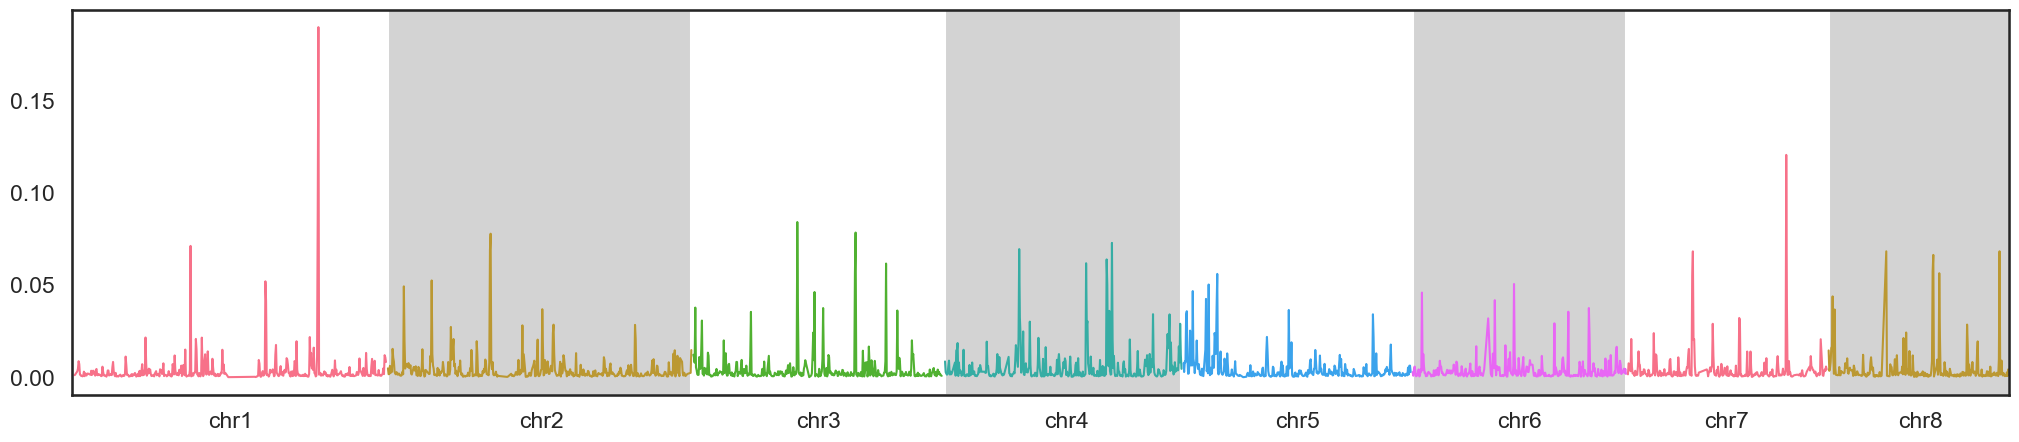

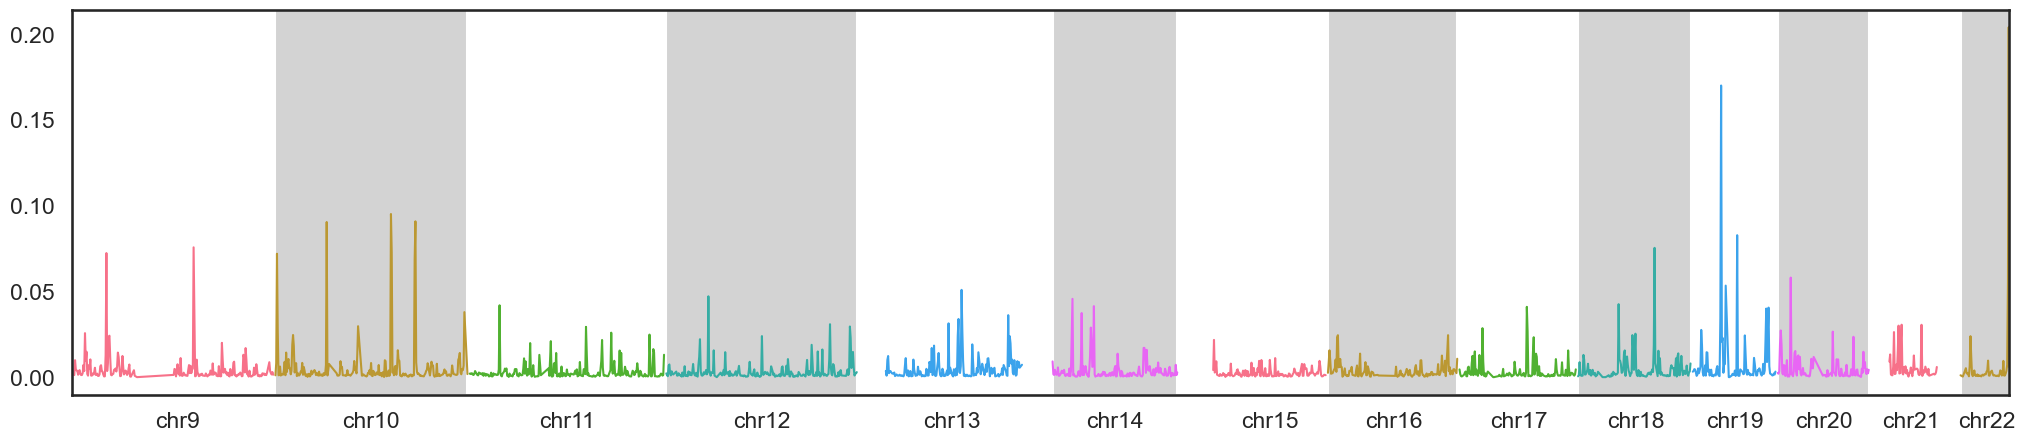

In [552]:

windows = pd.DataFrame(anc_div.mean(axis=1), columns=['mean_div'])

chroms = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8'] # did this to split the plot into a top panel and bottom, but you could just put all chroms here for 1 linear plot

fig = plt.figure(figsize=(25,5))
x_labels = []
x_labels_pos = []
ax = fig.add_subplot(111)
ax.set_facecolor('white')


maxLoc = 0
num = 0
for chrm in chroms:
    num+=1
    windows['center_loc'] = (windows.index.get_level_values(1) + 2**20)/2 + maxLoc # center_loc is the midway point in the region
    _ = plt.plot( 'center_loc','mean_div',data = windows.loc[chrm], lw=1.5)
    maxLoc = windows.loc[chrm]['center_loc'].max() + 10 # max loc iteratively becomes larger with each chromosome to place everything on the same x-axis. Remove the + 10 if you don't want space between the chroms
    x_labels_pos.append(windows.loc[chrm]['center_loc'].mean()) # save the position for the xlabels
    if (num % 2) == 0: # alternate gray and white background
        _ = ax.axvspan(windows.loc[chrm]['center_loc'].min(), windows.loc[chrm]['center_loc'].max(), facecolor='lightgray')
_ = ax.set_xticks(x_labels_pos)
_ = ax.set_xticklabels(chroms)
_ = ax.set_xlim(0,maxLoc)
#_ = ax.set_ylim(0,1.5)
maxLocOld = maxLoc
plt.show()


chroms = ['chr9','chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22']
fig = plt.figure(figsize=(25,5))
x_labels = []
x_labels_pos = []
ax = fig.add_subplot(111)
ax.set_facecolor('white')


maxLoc = 0
num = 0
for chrm in chroms:
    num+=1
    windows['center_loc'] = (windows.index.get_level_values(1) + 2**20)/2 + maxLoc # center_loc is the midway point in the region
    _ = plt.plot( 'center_loc','mean_div',data = windows.loc[chrm], lw=1.5)
    maxLoc = windows.loc[chrm]['center_loc'].max() + 10 # max loc iteratively becomes larger with each chromosome to place everything on the same x-axis. Remove the + 10 if you don't want space between the chroms
    x_labels_pos.append(windows.loc[chrm]['center_loc'].mean()) # save the position for the xlabels
    if (num % 2) == 0: # alternate gray and white background
        _ = ax.axvspan(windows.loc[chrm]['center_loc'].min(), windows.loc[chrm]['center_loc'].max(), facecolor='lightgray')
_ = ax.set_xticks(x_labels_pos)
_ = ax.set_xticklabels(chroms)
_ = ax.set_xlim(0,maxLoc)
#_ = ax.set_ylim(0,1.5)
maxLocOld = maxLoc
plt.show()

Text(0.5, 0, 'Chromosome 20 Position')

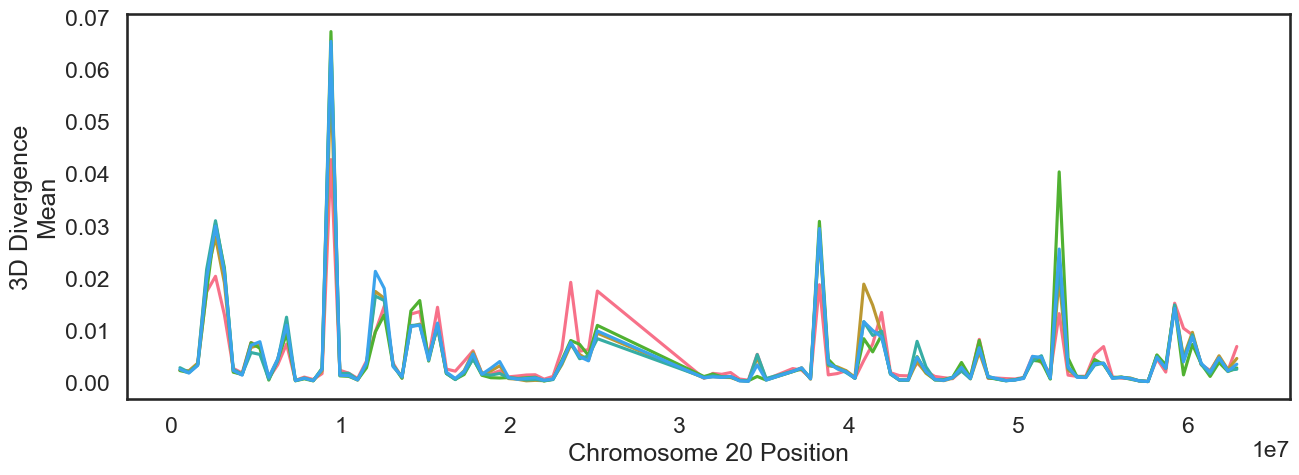

In [18]:
df = anc_div
chrm='chr20'

afr_avg = df['AFR'].mean(axis=1)
amr_avg = df['AMR'].mean(axis=1)
eur_avg = df['EUR'].mean(axis=1)
eas_avg = df['EAS'].mean(axis=1)
sas_avg = df['SAS'].mean(axis=1)

windows = pd.DataFrame([afr_avg, amr_avg, eur_avg, eas_avg, sas_avg]).transpose()
windows.columns = ['AFR','AMR','EUR','EAS','SAS']

windows['AVERAGE'] = windows.mean(axis=1)

df = windows.loc[chrm]

fig, ax = plt.subplots(figsize=[15,5])
sns.lineplot(y=df.AFR, 
             x=df.index, 
            label='AFR')
sns.lineplot(y=df.EUR, 
             x=df.index, 
            label='EUR')
sns.lineplot(y=df.EAS, 
             x=df.index, 
            label='EAS')
sns.lineplot(y=df.SAS, 
             x=df.index, 
            label='SAS')
sns.lineplot(y=df.AMR, 
             x=df.index, 
            label='AMR')


plt.legend([],[], frameon=False)

plt.ylabel('3D Divergence\nMean')
plt.xlabel('Chromosome 20 Position')

In [21]:
windows.loc['chr20'].loc[59768832]

AFR        0.010362
AMR        0.003913
EUR        0.004839
EAS        0.001419
SAS        0.004393
AVERAGE    0.004985
Name: 59768832, dtype: float64

Text(0.5, 0, 'Chromosome 20 Position')

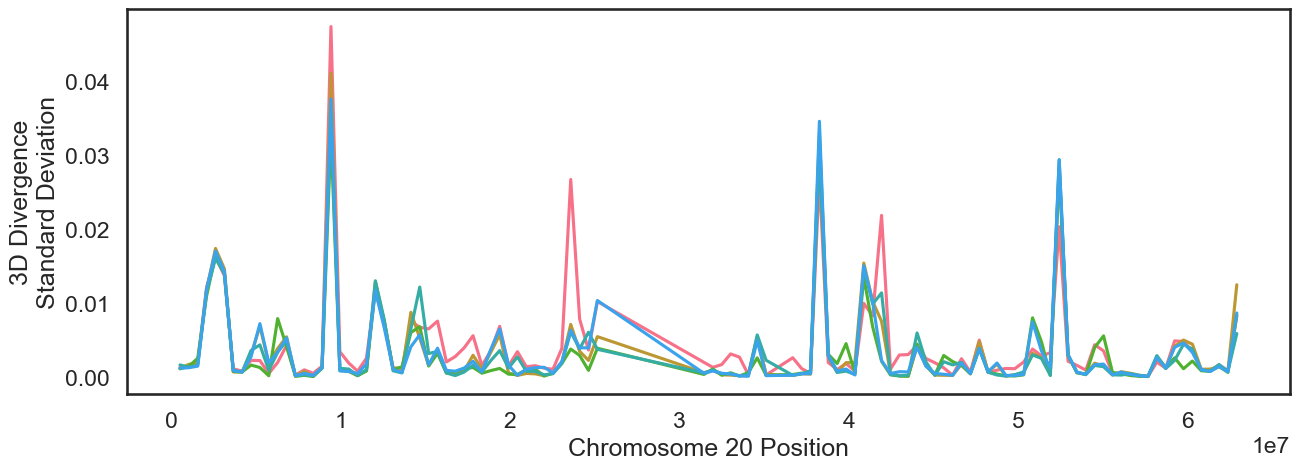

In [17]:
df = anc_div
chrm='chr20'

afr_avg = df['AFR'].std(axis=1)
amr_avg = df['AMR'].std(axis=1)
eur_avg = df['EUR'].std(axis=1)
eas_avg = df['EAS'].std(axis=1)
sas_avg = df['SAS'].std(axis=1)

windows = pd.DataFrame([afr_avg, amr_avg, eur_avg, eas_avg, sas_avg]).transpose()
windows.columns = ['AFR','AMR','EUR','EAS','SAS']

windows['AVERAGE'] = windows.mean(axis=1)

df = windows.loc[chrm]

fig, ax = plt.subplots(figsize=[15,5])
sns.lineplot(y=df.AFR, 
             x=df.index, 
            label='AFR')
sns.lineplot(y=df.EUR, 
             x=df.index, 
            label='EUR')
sns.lineplot(y=df.EAS, 
             x=df.index, 
            label='EAS')
sns.lineplot(y=df.SAS, 
             x=df.index, 
            label='SAS')
sns.lineplot(y=df.AMR, 
             x=df.index, 
            label='AMR')


plt.legend([],[], frameon=False)
plt.ylabel('3D Divergence\nStandard Deviation')
plt.xlabel('Chromosome 20 Position')


In [201]:
anc_div['AMR','PUR','female','HG01108'].idxmax()

('chr9', 22544384)

In [202]:
anc_div.loc['chr1',1048576]['AMR','PUR','female','HG01108']

0.0015560369301823584

In [203]:
afr_std =anc_div['AFR'].std(axis=1)
amr_std =anc_div['AMR'].std(axis=1)
eur_std =anc_div['EUR'].std(axis=1)
eas_std =anc_div['EAS'].std(axis=1)
sas_std =anc_div['SAS'].std(axis=1)

afr_avg =anc_div['AFR'].mean(axis=1)
amr_avg =anc_div['AMR'].mean(axis=1)
eur_avg =anc_div['EUR'].mean(axis=1)
eas_avg =anc_div['EAS'].mean(axis=1)
sas_avg =anc_div['SAS'].mean(axis=1)

windows_by_pop = pd.DataFrame([afr_avg, amr_avg, eur_avg, eas_avg, sas_avg, afr_std, amr_std, eur_std, eas_std, sas_std]).transpose()
windows_by_pop.columns = ['AFR_mean','AMR_mean','EUR_mean','EAS_mean','SAS_mean', 'AFR_std','AMR_std','EUR_std','EAS_std','SAS_std']

windows_by_pop['ALL_mean'] = anc_div.mean(axis=1)
windows_by_pop['ALL_std'] = anc_div.std(axis=1)


In [204]:
windows_by_pop

AFR_mean  AMR_mean  EUR_mean  EAS_mean  SAS_mean  \
chr   windowStartPos                                                     
chr1  1048576         0.001596  0.000881  0.000648  0.001091  0.000889   
      1572864         0.002087  0.001167  0.001148  0.001519  0.001216   
      3145728         0.002669  0.003333  0.002607  0.004419  0.002747   
      3670016         0.004773  0.004380  0.004600  0.004405  0.004836   
      4194304         0.009120  0.008632  0.009555  0.007170  0.008487   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.004763  0.003424  0.003324  0.003265  0.002981   
      47185920        0.011735  0.005060  0.004423  0.006339  0.006914   
      47710208        0.055222  0.059584  0.060998  0.053654  0.047924   
      48234496        0.204803  0.219469  0.214279  0.197077  0.187636   
      48758784        0.008367  0.005016  0.004276  0.004971  0.005018   

                       AFR_std   AMR_std   EUR_std   EAS_std   SAS_std  \
chr   windowStartPos                                                     
chr1  1048576         0.000834  0.000565  0.000449  0.002823  0.000436   
      1572864         0.001091  0.000576  0.000514  0.003997  0.000899   
      3145728         0.002707  0.002587  0.002303  0.002527  0.002268   
      3670016         0.001677  0.001306  0.004735  0.001116  0.001610   
      4194304         0.002968  0.003223  0.009507  0.002685  0.003270   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.002922  0.001475  0.004090  0.001231  0.001646   
      47185920        0.011732  0.003434  0.002042  0.003512  0.020782   
      47710208        0.024968  0.026555  0.028428  0.028623  0.022950   
      48234496        0.058776  0.064189  0.073819  0.066296  0.056998   
      48758784        0.003559  0.002211  0.001532  0.001635  0.001988   

                      ALL_mean   ALL_std  
chr   windowStartPos                      
chr1  1048576         0.001070  0.001436  
      1572864         0.001491  0.001996  
      3145728         0.003123  0.002591  
      3670016         0.004618  0.002516  
      4194304         0.008626  0.005136  
...                        ...       ...  
chr22 46661632        0.003650  0.002700  
      47185920        0.007318  0.011298  
      47710208        0.055384  0.026721  
      48234496        0.204137  0.064962  
      48758784        0.005755  0.002899  

[4873 rows x 12 columns]

## Overlap Genes with top 10% of windows

In [205]:
top_10 = windows_by_pop[windows_by_pop.ALL_mean >= (windows_by_pop.ALL_mean.quantile(.9))].index

In [206]:
top_10 = top_10.to_frame(index=False)

In [207]:
lower_90 = windows_by_pop[windows_by_pop.ALL_mean < (windows_by_pop.ALL_mean.quantile(.9))].index
lower_90 = lower_90.to_frame(index=False)

In [208]:
genes = pybedtools.BedTool('%s/annotations/grch38_gene_annotations.bed' % DATA_PATH)

In [209]:
all_windows = pd.DataFrame(index=windows_by_pop.index).reset_index()
all_windows.columns = ['chr','start']


In [210]:
all_windows['end'] = all_windows['start'] + 2**20
top_10['end'] = top_10['windowStartPos'] + 2**20
lower_90['end'] = lower_90['windowStartPos'] + 2**20

In [211]:
all_bed = pybedtools.BedTool.from_dataframe(all_windows)
top_bed = pybedtools.BedTool.from_dataframe(top_10)
lower_bed = pybedtools.BedTool.from_dataframe(lower_90)

In [212]:
gene_overlap_top = top_bed.intersect(genes, wao=True).to_dataframe(names=['window_chrm','start','end','gene_chr','gene_start','gene_end','gene_name','overlap'])
gene_overlap_all = all_bed.intersect(genes, wao=True).to_dataframe(names=['window_chrm','start','end','gene_chr','gene_start','gene_end','gene_name','overlap'])
gene_overlap_lower = lower_bed.intersect(genes, wao=True).to_dataframe(names=['window_chrm','start','end','gene_chr','gene_start','gene_end','gene_name','overlap'])

In [213]:
gene_overlap_all

window_chrm     start       end gene_chr  gene_start  gene_end  \
0            chr1   1048576   2097152     chr1     1070965   1074307   
1            chr1   1048576   2097152     chr1     1203507   1206571   
2            chr1   1048576   2097152     chr1     1232264   1235041   
3            chr1   1048576   2097152     chr1     1280435   1292019   
4            chr1   1048576   2097152     chr1     1311596   1324691   
...           ...       ...       ...      ...         ...       ...   
36897       chr22  46661632  47710208    chr22    46762620  47175693   
36898       chr22  47185920  48234496        .          -1        -1   
36899       chr22  47710208  48758784    chr22    48576305  48751932   
36900       chr22  48234496  49283072    chr22    48576305  48751932   
36901       chr22  48758784  49807360    chr22    49773282  49824804   

      gene_name  overlap  
0        RNF223     3342  
1      TNFRSF18     3064  
2       B3GALT6     2777  
3        SCNN1D    11584  
4        CPSF3L    13095  
...         ...      ...  
36897  TBC1D22A   413073  
36898         .        0  
36899   FAM19A5   175627  
36900   FAM19A5   175627  
36901      BRD1    34078  

[36902 rows x 8 columns]

In [214]:
gene_overlap_lower

window_chrm     start       end gene_chr  gene_start  gene_end  \
0            chr1   1048576   2097152     chr1     1070965   1074307   
1            chr1   1048576   2097152     chr1     1203507   1206571   
2            chr1   1048576   2097152     chr1     1232264   1235041   
3            chr1   1048576   2097152     chr1     1280435   1292019   
4            chr1   1048576   2097152     chr1     1311596   1324691   
...           ...       ...       ...      ...         ...       ...   
34352       chr22  46661632  47710208    chr22    46684410  46738261   
34353       chr22  46661632  47710208    chr22    46620401  46679785   
34354       chr22  46661632  47710208    chr22    46762620  47175693   
34355       chr22  47185920  48234496        .          -1        -1   
34356       chr22  48758784  49807360    chr22    49773282  49824804   

      gene_name  overlap  
0        RNF223     3342  
1      TNFRSF18     3064  
2       B3GALT6     2777  
3        SCNN1D    11584  
4        CPSF3L    13095  
...         ...      ...  
34352      CERK    53851  
34353    GRAMD4    18153  
34354  TBC1D22A   413073  
34355         .        0  
34356      BRD1    34078  

[34357 rows x 8 columns]

In [215]:
gene_overlap_top

window_chrm     start       end gene_chr  gene_start  gene_end gene_name  \
0           chr1  41418752  42467328     chr1    42153420  42155824    GUCA2B   
1           chr1  41418752  42467328     chr1    42162690  42164718    GUCA2A   
2           chr1  41418752  42467328     chr1    42456558  42460414      PPCS   
3           chr1  41418752  42467328     chr1    41478774  41484671      EDN2   
4           chr1  41418752  42467328     chr1    42380805  42422578    RIMKLA   
...          ...       ...       ...      ...         ...       ...       ...   
2540       chr22  44564480  45613056    chr22    44881161  45009700    PHF21B   
2541       chr22  44564480  45613056    chr22    45190337  45240769  KIAA0930   
2542       chr22  44564480  45613056    chr22    45344062  45413567     SMC1B   
2543       chr22  47710208  48758784    chr22    48576305  48751932   FAM19A5   
2544       chr22  48234496  49283072    chr22    48576305  48751932   FAM19A5   

      overlap  
0        2404  
1        2028  
2        3856  
3        5897  
4       41773  
...       ...  
2540   128539  
2541    50432  
2542    69505  
2543   175627  
2544   175627  

[2545 rows x 8 columns]

In [216]:
2556/36902

0.06926453850739797

In [217]:
34346/36902

0.930735461492602

In [218]:
(2556/36902) + (34346/36902)

1.0

## Shared top windows between populations

In [219]:
def check_top_percentile(windows_by_pop, percentile, metric):
    for pop in ['AFR','AMR','EUR','EAS','SAS']:
        windows_by_pop['%s_top'%pop] = windows_by_pop['%s_%s'%(pop, metric)]>= (windows_by_pop['%s_%s'%(pop, metric)].quantile(percentile))
    return windows_by_pop

In [220]:
windows_by_pop = check_top_percentile(windows_by_pop, 0.9, 'mean')

In [221]:
windows_by_pop

AFR_mean  AMR_mean  EUR_mean  EAS_mean  SAS_mean  \
chr   windowStartPos                                                     
chr1  1048576         0.001596  0.000881  0.000648  0.001091  0.000889   
      1572864         0.002087  0.001167  0.001148  0.001519  0.001216   
      3145728         0.002669  0.003333  0.002607  0.004419  0.002747   
      3670016         0.004773  0.004380  0.004600  0.004405  0.004836   
      4194304         0.009120  0.008632  0.009555  0.007170  0.008487   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.004763  0.003424  0.003324  0.003265  0.002981   
      47185920        0.011735  0.005060  0.004423  0.006339  0.006914   
      47710208        0.055222  0.059584  0.060998  0.053654  0.047924   
      48234496        0.204803  0.219469  0.214279  0.197077  0.187636   
      48758784        0.008367  0.005016  0.004276  0.004971  0.005018   

                       AFR_std   AMR_std   EUR_std   EAS_std   SAS_std  \
chr   windowStartPos                                                     
chr1  1048576         0.000834  0.000565  0.000449  0.002823  0.000436   
      1572864         0.001091  0.000576  0.000514  0.003997  0.000899   
      3145728         0.002707  0.002587  0.002303  0.002527  0.002268   
      3670016         0.001677  0.001306  0.004735  0.001116  0.001610   
      4194304         0.002968  0.003223  0.009507  0.002685  0.003270   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.002922  0.001475  0.004090  0.001231  0.001646   
      47185920        0.011732  0.003434  0.002042  0.003512  0.020782   
      47710208        0.024968  0.026555  0.028428  0.028623  0.022950   
      48234496        0.058776  0.064189  0.073819  0.066296  0.056998   
      48758784        0.003559  0.002211  0.001532  0.001635  0.001988   

                      ALL_mean   ALL_std  AFR_top  AMR_top  EUR_top  EAS_top  \
chr   windowStartPos                                                           
chr1  1048576         0.001070  0.001436    False    False    False    False   
      1572864         0.001491  0.001996    False    False    False    False   
      3145728         0.003123  0.002591    False    False    False    False   
      3670016         0.004618  0.002516    False    False    False    False   
      4194304         0.008626  0.005136    False    False     True    False   
...                        ...       ...      ...      ...      ...      ...   
chr22 46661632        0.003650  0.002700    False    False    False    False   
      47185920        0.007318  0.011298     True    False    False    False   
      47710208        0.055384  0.026721     True     True     True     True   
      48234496        0.204137  0.064962     True     True     True     True   
      48758784        0.005755  0.002899    False    False    False    False   

                      SAS_top  
chr   windowStartPos           
chr1  1048576           False  
      1572864           False  
      3145728           False  
      3670016           False  
      4194304           False  
...                       ...  
chr22 46661632          False  
      47185920          False  
      47710208           True  
      48234496           True  
      48758784          False  

[4873 rows x 17 columns]

In [222]:
top_windows_by_pop = windows_by_pop[['AFR_top','AMR_top','EUR_top','EAS_top','SAS_top']]
top_windows_by_pop = top_windows_by_pop[(top_windows_by_pop ==True).any(axis=1)]

In [223]:
def upset(pops_out):
    indicators = pops_out.reset_index().drop(columns=['chr','windowStartPos'])
    listy = pops_out.index
    listx=[]
    for i in listy:
        listx.append(str(i))
    data = pd.DataFrame({"value": listx, **indicators})
    ind_dict = {}
    for pop in indicators.columns:
        ind_dict[pop] = list(indicators[pop].values)
    e = from_indicators(ind_dict, data = data)
    fig= plt.figure(figsize=(15,5))
    plot(e, fig=fig, element_size=None, sort_by='cardinality', show_counts=True)
    return

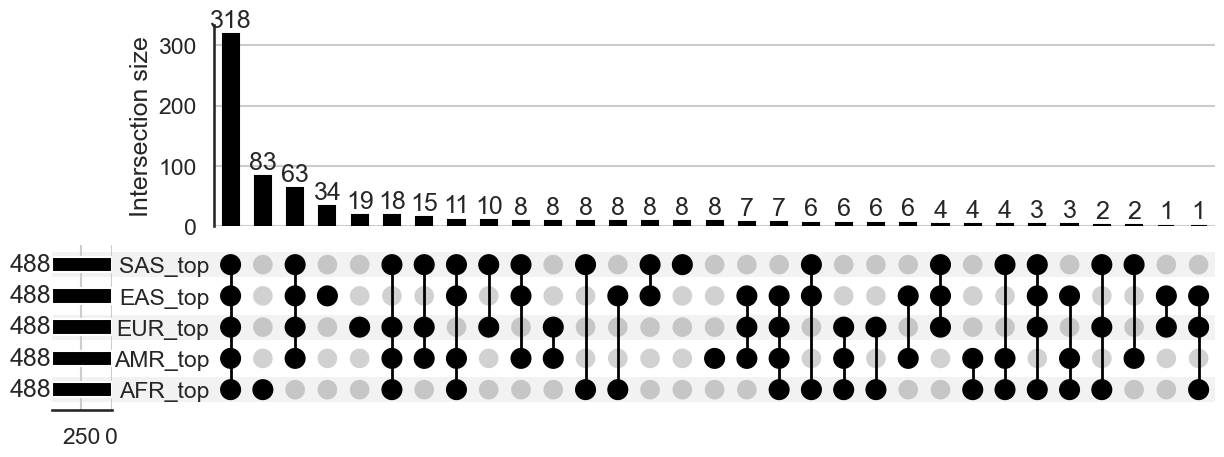

In [533]:
upset(top_windows_by_pop)

In [225]:
318+69+59+32+19+18+14+11+9+9+8+8+(7*3)+(6*3)+(5*3)+(4*3)+(3*8)+(2*8)+(1*9)

689

In [226]:
top_windows_by_pop.shape

(689, 5)

In [227]:
top_windows_by_pop

AFR_top  AMR_top  EUR_top  EAS_top  SAS_top
chr   windowStartPos                                             
chr1  4194304           False    False     True    False    False
      31457280           True    False    False    False    False
      41418752           True    False     True     True     True
      57147392          False     True     True     True     True
      57671680          False     True    False    False    False
...                       ...      ...      ...      ...      ...
chr22 34078720           True     True    False    False     True
      44564480          False     True     True     True     True
      47185920           True    False    False    False    False
      47710208           True     True     True     True     True
      48234496           True     True     True     True     True

[689 rows x 5 columns]

## Annotate Quantiles

In [534]:
# read in annotations
phastCons = pybedtools.BedTool('%s/annotations/phastConsElements100way_hg38.bed' % DATA_PATH)
ctcf = pybedtools.BedTool('%s/annotations/unique_all.bed' % DATA_PATH).merge()
rmsk = pybedtools.BedTool('%s/annotations/rmsk_hg38.bed' % DATA_PATH)

In [535]:
rmsk.to_dataframe()

chrom     start       end       name  score strand
0                           chr1  67108753  67109046       L1P5   1892      +
1                           chr1   8388315   8388618       AluY   2582      -
2                           chr1  25165803  25166380      L1MB5   4085      +
3                           chr1  33554185  33554483      AluSc   2285      -
4                           chr1  41942894  41943205       AluY   2451      -
...                          ...       ...       ...        ...    ...    ...
5683685  chr22_KI270739v1_random     42471     42520   Tigger5b    270      -
5683686  chr22_KI270739v1_random     42530     48656  ALR/Alpha   1296      -
5683687  chr22_KI270739v1_random     48656     49096      L1PA3   3289      -
5683688  chr22_KI270739v1_random     49091     50070      L1PA3   6957      +
5683689  chr22_KI270739v1_random     50070     73985  ALR/Alpha   1338      -

[5683690 rows x 6 columns]

In [536]:
def PercentileToQuantile(x, bins):
    if bins==4:
        if x < 0.25:
            return 1
        elif x < 0.5:
            return 2
        elif x < 0.75:
            return 3
        else:
            return 4
    if bins ==10:
        if x < 0.1:
            return 1
        if x < 0.2:
            return 2
        if x < 0.3:
            return 3
        if x < 0.4:
            return 4
        if x < 0.5:
            return 5
        if x < 0.6:
            return 6
        if x < 0.7:
            return 7
        if x < 0.8:
            return 8
        if x < 0.9:
            return 9
        else:
            return 10
        

In [231]:
def QuantAnnotate(windows_by_pop, annot_data, annot_type, quant_bins):
    regions = windows_by_pop[['ALL_mean','ALL_std']]
    regions['divergence_percentile'] = regions['ALL_mean'].rank(pct=True)
    regions = regions.reset_index()
    regions['divergence_percentile_group'] = regions['divergence_percentile'].apply(PercentileToQuantile, bins=quant_bins)
    regions['stop'] = regions['windowStartPos'] + 2**20
    regions = regions[['chr','windowStartPos','stop','ALL_mean','ALL_std','divergence_percentile','divergence_percentile_group']]
    regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
    region_list = regions[['chr','start','stop', 'divergence_percentile_group']]

    if annot_type == 'genes':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','gene_name','numBases']
        annotation['annot_count'] = 1
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group'], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'divergence_percentile_group':'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='ctcf':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','numBases']
        annotation['annot_count'] = 1
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group'], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'divergence_percentile_group':'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='phastCons':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','lod','phastCons_score','numBases']
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group'], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','phastCons_score':'mean', 'divergence_percentile_group':'mean'})
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='rmsk':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','repeat_type','repeat_score','strand','numBases']
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group'], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','repeat_score':'mean', 'divergence_percentile_group':'mean'})
        annotation_grouped= annotation_grouped.reset_index()
    return annotation_grouped

#### Rebinning?

In [381]:
windows_by_pop.ALL_mean.min()

2.9357795668096296e-11

In [382]:
windows_by_pop.ALL_mean.max()

0.20413700814713476

In [383]:
np.linspace(windows_by_pop.ALL_mean.min(),windows_by_pop.ALL_mean.max(),11)

array([2.93577957e-11, 2.04137008e-02, 4.08274017e-02, 6.12411025e-02,
       8.16548033e-02, 1.02068504e-01, 1.22482205e-01, 1.42895906e-01,
       1.63309607e-01, 1.83723307e-01, 2.04137008e-01])

In [384]:
for i in range(1,10):
    print(i)

1
2
3
4
5
6
7
8
9


In [385]:
def ScoreToBin(x, nbins):
    mini  = windows_by_pop.ALL_mean.min()
    maxi = windows_by_pop.ALL_mean.max()
    top_bin_low = np.linspace(mini,maxi,nbins+1)[1]
    bins = np.linspace(mini,top_bin_low,nbins)
    bins = np.append(bins, maxi)
    for i in range(1,nbins+1):
        if x <= bins[i]:
            return float(i)


In [386]:
regions = windows_by_pop[['ALL_mean','ALL_std']]
regions = regions.reset_index()
regions['bin'] = regions['ALL_mean'].apply(ScoreToBin, nbins=10)
regions['stop'] = regions['windowStartPos'] + 2**20
regions = regions[['chr','windowStartPos','stop','ALL_mean','ALL_std','bin']]
regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
region_list = regions[['chr','start','stop', 'bin']]

<Axes: ylabel='Frequency'>

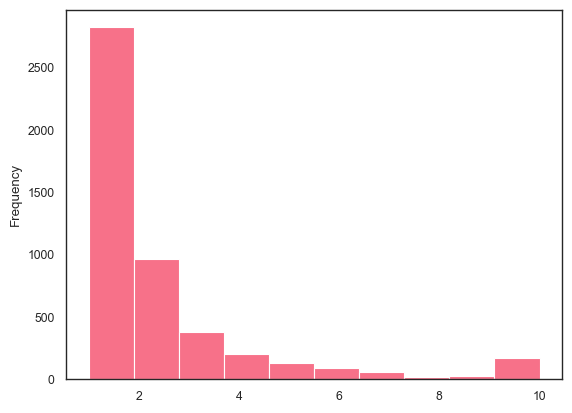

In [389]:
region_list.bin.plot.hist()

<Axes: ylabel='Frequency'>

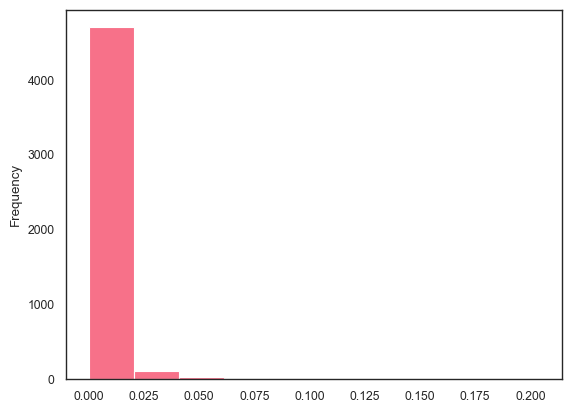

In [53]:
regions.ALL_mean.plot.hist()

In [74]:
region_list.bin.value_counts()

1.0     2821
2.0      963
3.0      381
4.0      203
10.0     173
5.0      135
6.0       89
7.0       60
9.0       27
8.0       21
Name: bin, dtype: int64

<AxesSubplot: ylabel='Frequency'>

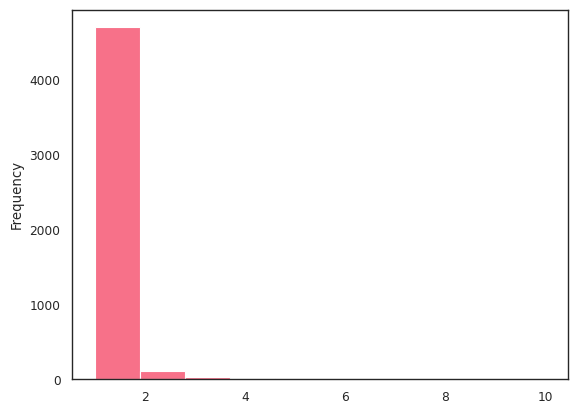

In [66]:
region_list.bin.plot.hist()

In [51]:
def BinAnnotate(windows_by_pop, annot_data, annot_type, nbins):
    regions = windows_by_pop[['ALL_mean','ALL_std']]
    regions = regions.reset_index()
    regions['bin'] = regions['ALL_mean'].apply(ScoreToBin, nbins=nbins)
    regions['stop'] = regions['windowStartPos'] + 2**20
    regions = regions[['chr','windowStartPos','stop','ALL_mean','ALL_std','bin']]
    regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
    region_list = regions[['chr','start','stop', 'bin']]

    if annot_type == 'genes':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','gene_name','numBases']
        annotation['annot_count'] = 1
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'bin'], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'bin':'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='ctcf':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','numBases']
        annotation['annot_count'] = 1
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'bin'], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'bin':'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='phastCons':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','lod','phastCons_score','numBases']
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'bin'], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','phastCons_score':'mean', 'bin':'mean'})
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='rmsk':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','repeat_type','repeat_score','strand','numBases']
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'bin'], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','repeat_score':'mean', 'bin':'mean'})
        annotation_grouped= annotation_grouped.reset_index()
    return annotation_grouped

### Genes

r2 =  0.014855685889987785 p = 1.3656455615478162e-17


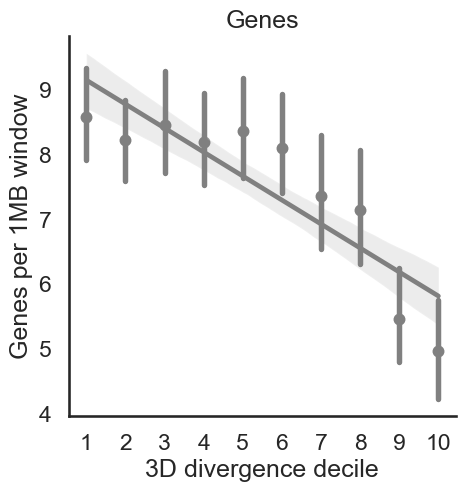

In [541]:
annotation = QuantAnnotate(windows_by_pop, annot_data = genes, annot_type = 'genes', quant_bins=10)
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="3D divergence decile", ylabel="Genes per 1MB window", title='Genes')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

r2 =  0.0024678616126364173 p = 0.0005222270510975727


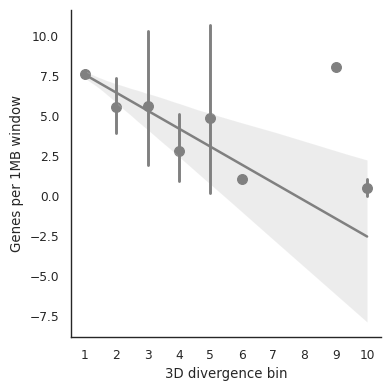

In [55]:
annotation = BinAnnotate(windows_by_pop, annot_data = genes, annot_type = 'genes', nbins=10)
g = sns.lmplot(x='bin', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=4)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="3D divergence bin", ylabel="Genes per 1MB window")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['bin'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

### CTCF

r2 =  0.008826269534127625 p = 4.994921071935427e-11


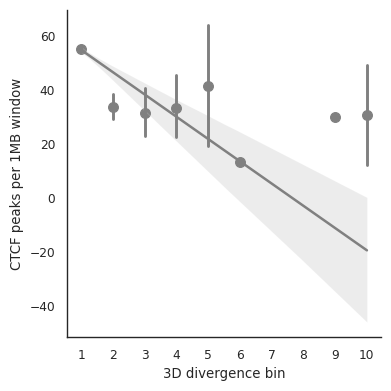

In [56]:
annotation = BinAnnotate(windows_by_pop, annot_data=ctcf, annot_type='ctcf', nbins=10)
g = sns.lmplot(x='bin', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=4)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="3D divergence bin", ylabel="CTCF peaks per 1MB window")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['bin'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

r2 =  0.041057824969152695 p = 2.5397539374860983e-46


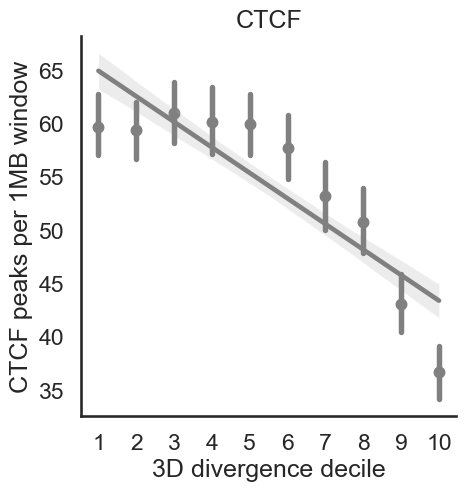

In [543]:

annotation = QuantAnnotate(windows_by_pop, annot_data=ctcf, annot_type='ctcf', quant_bins=10)
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="3D divergence decile", ylabel="CTCF peaks per 1MB window", title='CTCF')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

In [58]:
annotation

chr      start       stop  numBases  annot_count  \
0     chr1    1048576    2097152   97642.0        130.0   
1     chr1    1572864    2621440  112422.0        153.0   
2     chr1    3145728    4194304   67757.0        106.0   
3     chr1    3670016    4718592   30844.0         45.0   
4     chr1    4194304    5242880   19567.0         31.0   
...    ...        ...        ...       ...          ...   
4868  chr9  134742016  135790592   32785.0         56.0   
4869  chr9  135266304  136314880   60135.0         94.0   
4870  chr9  135790592  136839168  117083.0        168.0   
4871  chr9  136314880  137363456  158414.0        212.0   
4872  chr9  136839168  137887744  122821.0        166.0   

      divergence_percentile_group  propBasesCovered  
0                             4.0          0.093119  
1                             5.0          0.107214  
2                             7.0          0.064618  
3                             8.0          0.029415  
4                             9.0          0.018661  
...                           ...               ...  
4868                          8.0          0.031266  
4869                          6.0          0.057349  
4870                          5.0          0.111659  
4871                          7.0          0.151075  
4872                          5.0          0.117131  

[4873 rows x 7 columns]

### RMSK

In [404]:
windows_by_pop

AFR_mean  AMR_mean  EUR_mean  EAS_mean  SAS_mean  \
chr   windowStartPos                                                     
chr1  1048576         0.001596  0.000881  0.000648  0.001091  0.000889   
      1572864         0.002087  0.001167  0.001148  0.001519  0.001216   
      3145728         0.002669  0.003333  0.002607  0.004419  0.002747   
      3670016         0.004773  0.004380  0.004600  0.004405  0.004836   
      4194304         0.009120  0.008632  0.009555  0.007170  0.008487   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.004763  0.003424  0.003324  0.003265  0.002981   
      47185920        0.011735  0.005060  0.004423  0.006339  0.006914   
      47710208        0.055222  0.059584  0.060998  0.053654  0.047924   
      48234496        0.204803  0.219469  0.214279  0.197077  0.187636   
      48758784        0.008367  0.005016  0.004276  0.004971  0.005018   

                       AFR_std   AMR_std   EUR_std   EAS_std   SAS_std  \
chr   windowStartPos                                                     
chr1  1048576         0.000834  0.000565  0.000449  0.002823  0.000436   
      1572864         0.001091  0.000576  0.000514  0.003997  0.000899   
      3145728         0.002707  0.002587  0.002303  0.002527  0.002268   
      3670016         0.001677  0.001306  0.004735  0.001116  0.001610   
      4194304         0.002968  0.003223  0.009507  0.002685  0.003270   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.002922  0.001475  0.004090  0.001231  0.001646   
      47185920        0.011732  0.003434  0.002042  0.003512  0.020782   
      47710208        0.024968  0.026555  0.028428  0.028623  0.022950   
      48234496        0.058776  0.064189  0.073819  0.066296  0.056998   
      48758784        0.003559  0.002211  0.001532  0.001635  0.001988   

                      ALL_mean   ALL_std  AFR_top  AMR_top  EUR_top  EAS_top  \
chr   windowStartPos                                                           
chr1  1048576         0.001070  0.001436    False    False    False    False   
      1572864         0.001491  0.001996    False    False    False    False   
      3145728         0.003123  0.002591    False    False    False    False   
      3670016         0.004618  0.002516    False    False    False    False   
      4194304         0.008626  0.005136    False    False     True    False   
...                        ...       ...      ...      ...      ...      ...   
chr22 46661632        0.003650  0.002700    False    False    False    False   
      47185920        0.007318  0.011298     True    False    False    False   
      47710208        0.055384  0.026721     True     True     True     True   
      48234496        0.204137  0.064962     True     True     True     True   
      48758784        0.005755  0.002899    False    False    False    False   

                      SAS_top  
chr   windowStartPos           
chr1  1048576           False  
      1572864           False  
      3145728           False  
      3670016           False  
      4194304           False  
...                       ...  
chr22 46661632          False  
      47185920          False  
      47710208           True  
      48234496           True  
      48758784          False  

[4873 rows x 17 columns]

r2 =  0.0013921023244588067 p = 0.009192917940752646


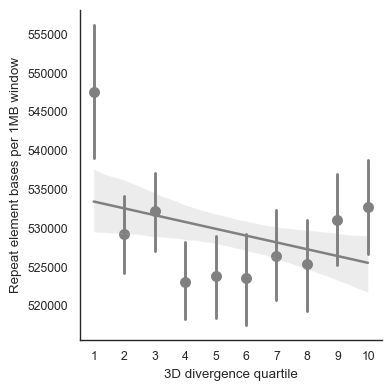

In [405]:
annotation = QuantAnnotate(windows_by_pop, annot_data=rmsk, annot_type='rmsk', quant_bins=10)
g = sns.lmplot(x='divergence_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=4)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="3D divergence quartile", ylabel="Repeat element bases per 1MB window")
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['numBases'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

In [406]:
rmsk_map = pd.read_table('%s/annotations/repeatmasker_name_class_family.tab' % DATA_PATH, header = None, names=['name','class','family'])
rmsk_map

name          class         family
0              (A)n  Simple_repeat  Simple_repeat
1            (AAA)n  Simple_repeat  Simple_repeat
2        (AAAAAAC)n  Simple_repeat  Simple_repeat
3        (AAAAAAG)n  Simple_repeat  Simple_repeat
4        (AAAAAAT)n  Simple_repeat  Simple_repeat
...             ...            ...            ...
15669  tRNA-Tyr-TAC           tRNA           tRNA
15670  tRNA-Tyr-TAT           tRNA           tRNA
15671  tRNA-Val-GTA           tRNA           tRNA
15672  tRNA-Val-GTG           tRNA           tRNA
15673  tRNA-Val-GTY           tRNA           tRNA

[15674 rows x 3 columns]

In [508]:
annot_data=rmsk
annot_type='rmsk'
quant_bins=10
regions = windows_by_pop[['ALL_mean','ALL_std']]
regions['divergence_percentile'] = regions['ALL_mean'].rank(pct=True)
regions = regions.reset_index()
regions['divergence_percentile_group'] = regions['divergence_percentile'].apply(PercentileToQuantile, bins=quant_bins)
regions['stop'] = regions['windowStartPos'] + 2**20
regions = regions[['chr','windowStartPos','stop','ALL_mean','ALL_std','divergence_percentile','divergence_percentile_group']]
regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
region_list = regions[['chr','start','stop', 'divergence_percentile_group']]

annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','repeat_name','repeat_score','strand','numBases']
annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group'], how='outer')
annotation = annotation.merge(rmsk_map, left_on='repeat_name', right_on='name')
repeat_sums_counts= pd.DataFrame(annotation.groupby(['class','divergence_percentile_group'])['numBases'].agg(['sum','count'])).reset_index()
repeat_sums_counts = repeat_sums_counts.pivot(index='class', columns = 'divergence_percentile_group')


In [410]:
blues = ['#d6e5f2',
         '#b1cee6',
         '#8cb6da',
         '#679fce',
         '#4288c2',
         '#336ea0',
         '#27557b',
         '#1b3b56',
         '#0f2231',
         '#03080c'
         ]

#### x axis repeat type

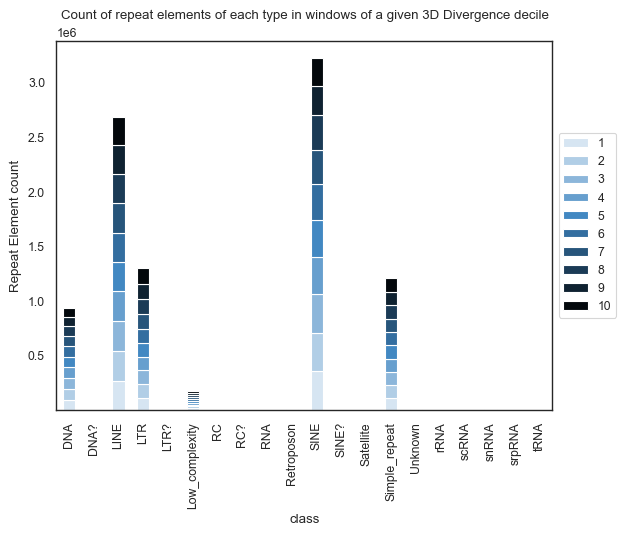

In [412]:
df.plot(kind='bar', stacked='True', color=blues)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Count of repeat elements of each type in windows of a given 3D Divergence decile')
plt.ylabel('Repeat Element count')
plt.show()

In [ ]:
cols = list(df.columns)
df1 = df.copy()
df1[cols] = df[cols].div(df[cols].sum(axis=1), axis=0).multiply(100)
df1.plot(kind='bar', stacked='True', color=blues)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Proportion of repeat elements of each type in windows of a given 3D Divergence decile')
plt.ylabel('Repeat Element Proportion')
plt.show()

#### x axis deciles

In [415]:
g, p, dof, expctd = stats.chi2_contingency(df, lambda_='log-likelihood')

In [511]:
repeat_counts_t = repeat_sums_counts['count'].T
repeat_counts_t['DNA'] = repeat_counts_t['DNA'] + repeat_counts_t['DNA?']
repeat_counts_t['LTR'] = repeat_counts_t['LTR'] + repeat_counts_t['LTR?']
repeat_counts_t['RC'] = repeat_counts_t['RC'] + repeat_counts_t['RC?']
repeat_counts_t['SINE'] = repeat_counts_t['SINE'] + repeat_counts_t['SINE?']
repeat_counts_t = repeat_counts_t.drop(columns=['DNA?','LTR?','RC?','SINE?'])

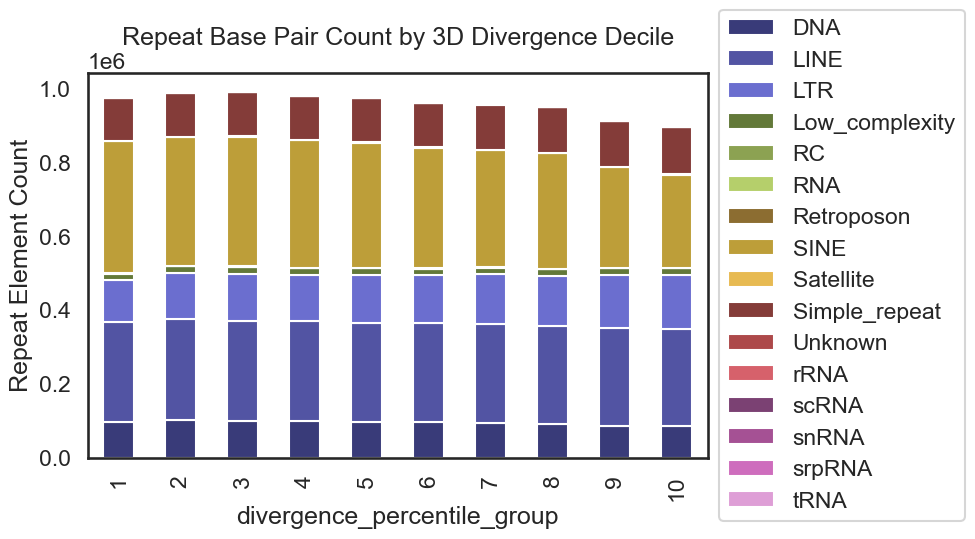

In [526]:

repeat_counts_t.plot(kind='bar', stacked='True', cmap ='tab20b', figsize=(8,5))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Repeat Base Pair Count by 3D Divergence Decile')
plt.ylabel('Repeat Element Count')
#plt.legend(bbox_to_anchor=(1, 1))
plt.show()

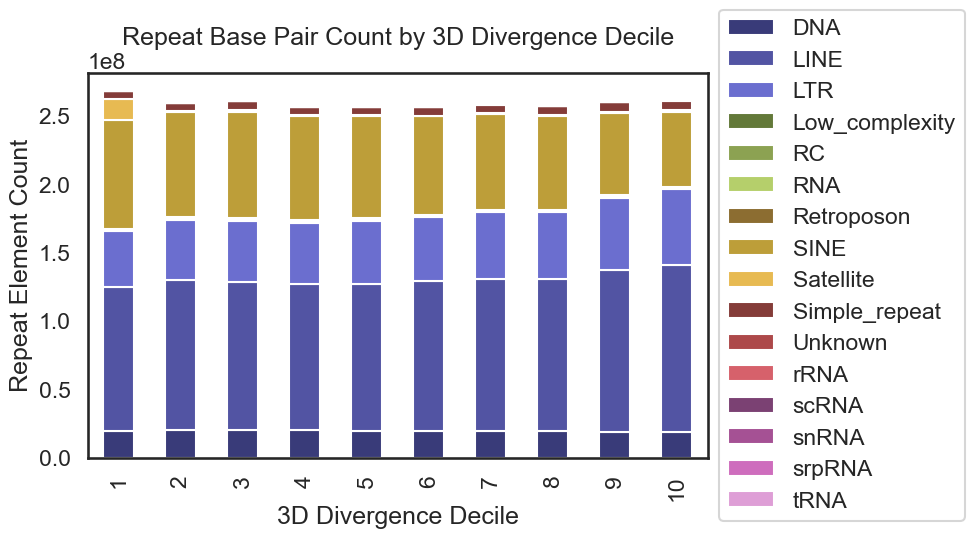

In [530]:
repeat_sums_t = repeat_sums_counts['sum'].T
repeat_sums_t['DNA'] = repeat_sums_t['DNA'] + repeat_sums_t['DNA?']
repeat_sums_t['LTR'] = repeat_sums_t['LTR'] + repeat_sums_t['LTR?']
repeat_sums_t['RC'] = repeat_sums_t['RC'] + repeat_sums_t['RC?']
repeat_sums_t['SINE'] = repeat_sums_t['SINE'] + repeat_sums_t['SINE?']
repeat_sums_t = repeat_sums_t.drop(columns=['DNA?','LTR?','RC?','SINE?'])

repeat_sums_t.plot(kind='bar', stacked='True', cmap ='tab20b', figsize=(8,5))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Repeat Base Pair Count by 3D Divergence Decile')
plt.ylabel('Repeat Element Count')

plt.xlabel('3D Divergence Decile')
#plt.legend(bbox_to_anchor=(1, 1))
plt.show()

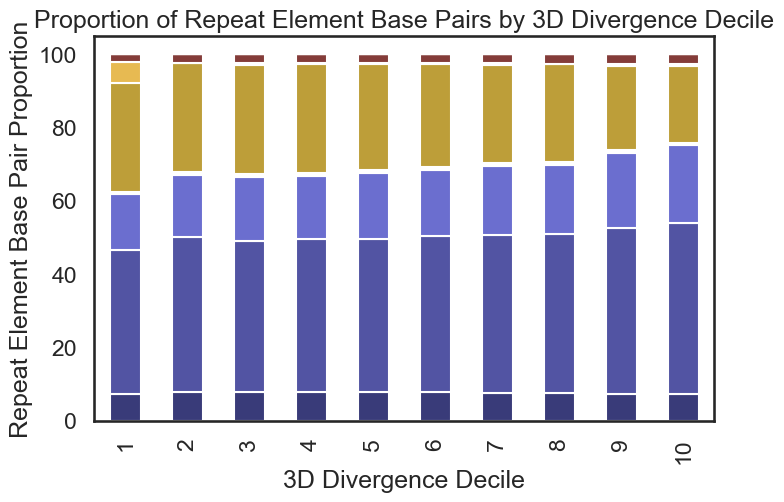

In [532]:
repeat_sums_t = repeat_sums_t.copy()
cols = list(repeat_sums_t.columns)
repeat_sums_t[cols] = repeat_sums_t[cols].div(repeat_sums_t[cols].sum(axis=1), axis=0).multiply(100)

repeat_sums_t.plot(kind='bar', stacked='True', cmap ='tab20b', figsize=(8,5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Proportion of Repeat Element Base Pairs by 3D Divergence Decile')
plt.ylabel('Repeat Element Base Pair Proportion')

plt.xlabel('3D Divergence Decile')
plt.legend('',frameon=False)
plt.show()

#### More granular

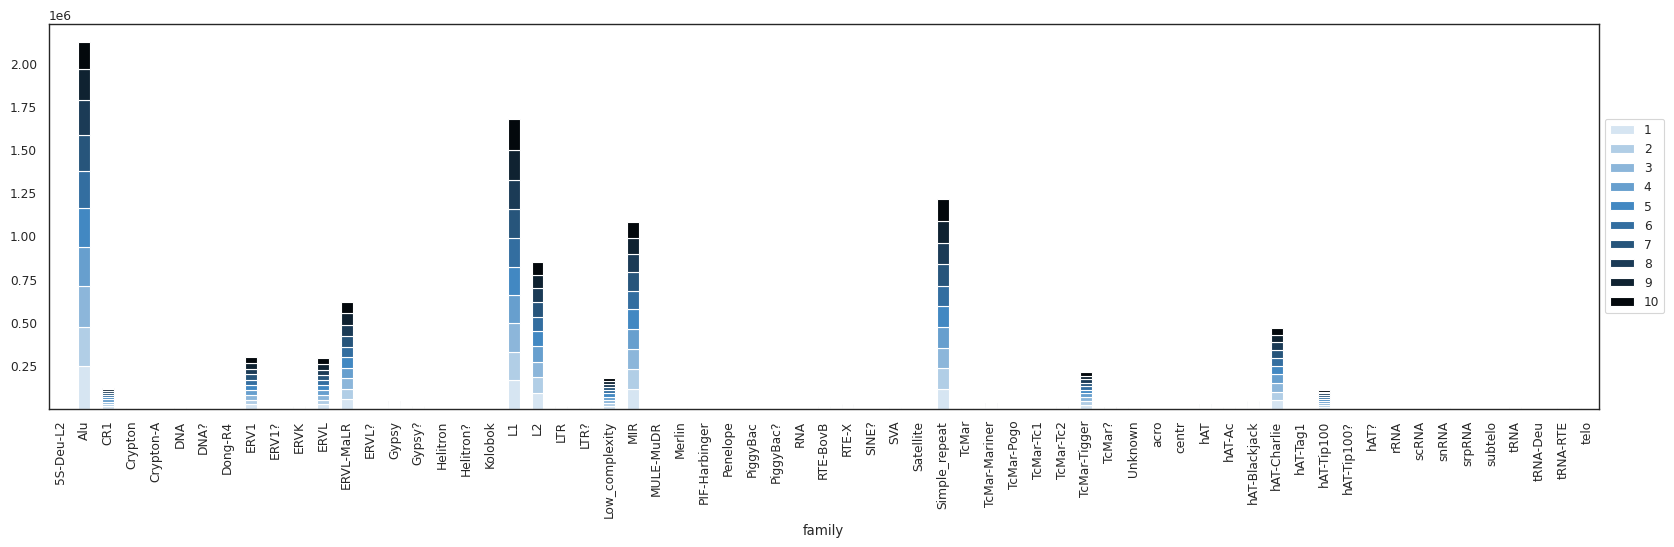

In [ ]:
df2 = pd.DataFrame(annotation.groupby(['family','divergence_percentile_group']).size()).reset_index()
df2 = df2.pivot(index='family', columns = 'divergence_percentile_group')[0]

df2.plot(kind='bar', stacked='True', color=blues, figsize=(20,5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

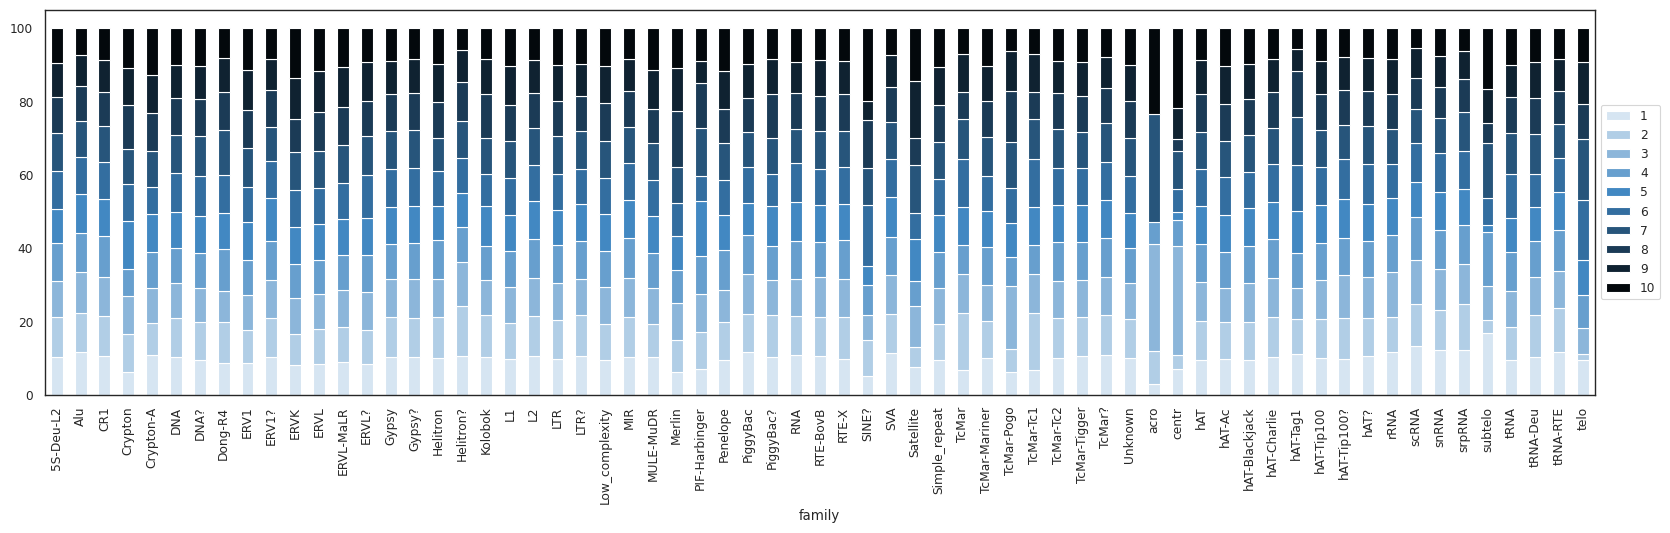

In [ ]:
cols = list(df.columns)
df3 = df2.copy()
df3[cols] = df2[cols].div(df2[cols].sum(axis=1), axis=0).multiply(100)
df3.plot(kind='bar', stacked='True', color=blues, figsize=(20,5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Phast Cons

In [547]:
annotation = QuantAnnotate(windows_by_pop, annot_data=phastCons, annot_type='phastCons',quant_bins=10) 

r2 =  0.04474058960099936 p = 2.0718659165587477e-50


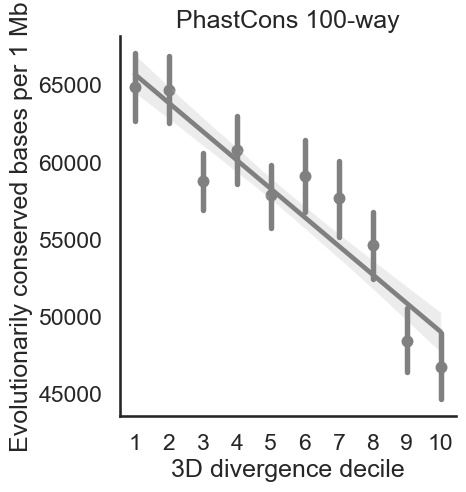

In [548]:
g = sns.lmplot(x='divergence_percentile_group', y='numBases', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="3D divergence decile", ylabel="Evolutionarily conserved bases per 1 Mb", title='PhastCons 100-way')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['numBases'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

### Seq ID

In [549]:
windows_by_pop['seq_id_all'] = seq_id.mean(axis=1)

In [550]:
windows_by_pop['divergence_percentile'] = windows_by_pop['ALL_mean'].rank(pct=True)
windows_by_pop['divergence_percentile_group'] = windows_by_pop['divergence_percentile'].apply(PercentileToQuantile, bins=10)

r2 =  0.11358060308548364 p = 1.011950598290596e-129


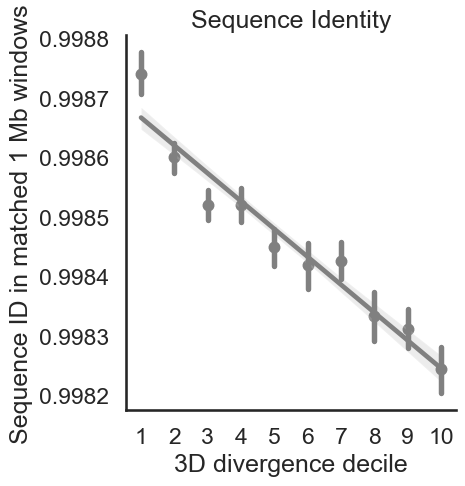

In [551]:
g = sns.lmplot(x='divergence_percentile_group', y='seq_id_all', data=windows_by_pop, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="3D divergence decile", ylabel="Sequence ID in matched 1 Mb windows", title='Sequence Identity')
slope, intercept, r_value, p_value, std_err = stats.linregress(windows_by_pop['divergence_percentile_group'],windows_by_pop['seq_id_all'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))

### Other annotations

In [432]:
spin = pybedtools.BedTool('%s/annotations/K562_SPIN_25kb_hg38.bed' % DATA_PATH)

In [471]:
spin_df = spin.to_dataframe()
regions = windows_by_pop[['ALL_mean','ALL_std']]
regions['divergence_percentile'] = regions['ALL_mean'].rank(pct=True)
regions = regions.reset_index()
regions['divergence_percentile_group'] = regions['divergence_percentile'].apply(PercentileToQuantile, bins=10)
regions['stop'] = regions['windowStartPos'] + 2**20
regions = regions[['chr','windowStartPos','stop','ALL_mean','ALL_std','divergence_percentile','divergence_percentile_group']]
regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
region_list = regions[['chr','start','stop', 'divergence_percentile_group']]
annotation = BedTool.from_dataframe(regions).intersect(spin, wo=True).to_dataframe(disable_auto_names=True, header=None)
annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','spin_state','numBases']
annotation['annot_count'] = 1
annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group'], how='outer')

spin_sums_counts= pd.DataFrame(annotation.groupby(['spin_state','divergence_percentile_group'])['numBases'].agg(['sum','count'])).reset_index()
spin_sums_counts = spin_sums_counts.pivot(index='spin_state', columns = 'divergence_percentile_group')


In [472]:
stats.chi2_contingency(spin_sums_counts['count'], lambda_='log-likelihood')

Chi2ContingencyResult(statistic=370.8966453099757, pvalue=1.1209766843133634e-38, dof=81, expected_freq=array([[ 94.82243872,  98.64079195,  95.88309239,  96.02451288,
         91.14550597,  94.11533627,  90.01414205,  83.22595852,
         80.96323067,  75.16499057],
       [ 96.19209617, 100.06560339,  97.2680704 ,  97.41153363,
         92.46205217,  95.47478001,  91.31434632,  84.42811125,
         82.13269956,  76.2507071 ],
       [204.2896763 , 212.51610622, 206.57479573, 206.87947832,
        196.36792898, 202.76626336, 193.93046826, 179.30570396,
        174.43078253, 161.93879635],
       [ 63.42567568,  65.97972973,  64.13513514,  64.22972973,
         60.96621622,  62.9527027 ,  60.20945946,  55.66891892,
         54.15540541,  50.27702703],
       [ 83.54910434,  86.9134978 ,  84.48365808,  84.60826524,
         80.30931804,  82.92606851,  79.31246072,  73.33131678,
         71.33760214,  66.22870836],
       [242.64008485, 252.41082652, 245.35417976, 245.71605908,
       

In [475]:
stats.chi2_contingency(spin_sums_counts['sum'], lambda_='log-likelihood')

Chi2ContingencyResult(statistic=347264997.7080838, pvalue=0.0, dof=81, expected_freq=array([[3.74244018e+07, 3.85403625e+07, 3.85384099e+07, 3.85853173e+07,
        3.85403625e+07, 3.85112658e+07, 3.86140909e+07, 3.85347021e+07,
        3.85403625e+07, 3.86195008e+07],
       [3.59510642e+07, 3.70230914e+07, 3.70212156e+07, 3.70662764e+07,
        3.70230914e+07, 3.69951402e+07, 3.70939173e+07, 3.70176538e+07,
        3.70230914e+07, 3.70991142e+07],
       [6.58920142e+07, 6.78568525e+07, 6.78534146e+07, 6.79360032e+07,
        6.78568525e+07, 6.78056230e+07, 6.79866640e+07, 6.78468864e+07,
        6.78568525e+07, 6.79961890e+07],
       [2.10328179e+07, 2.16599969e+07, 2.16588995e+07, 2.16852619e+07,
        2.16599969e+07, 2.16436443e+07, 2.17014329e+07, 2.16568157e+07,
        2.16599969e+07, 2.17044733e+07],
       [2.93640970e+07, 3.02397070e+07, 3.02381749e+07, 3.02749796e+07,
        3.02397070e+07, 3.02168770e+07, 3.02975561e+07, 3.02352657e+07,
        3.02397070e+07, 3.03018

In [470]:
spin_sums_counts

spin_state  divergence_percentile_group         sum  count
0   Interior_Act1                            1  53405336.0    112
1   Interior_Act1                            2  50021264.0    100
2   Interior_Act1                            3  43031040.0     97
3   Interior_Act1                            4  42080152.0    104
4   Interior_Act1                            5  42379608.0     94
..            ...                          ...         ...    ...
95        Speckle                            6  35413536.0     61
96        Speckle                            7  24225256.0     39
97        Speckle                            8  37972336.0     58
98        Speckle                            9  20907040.0     38
99        Speckle                           10  11437984.0     19

[100 rows x 4 columns]

#### X axis states

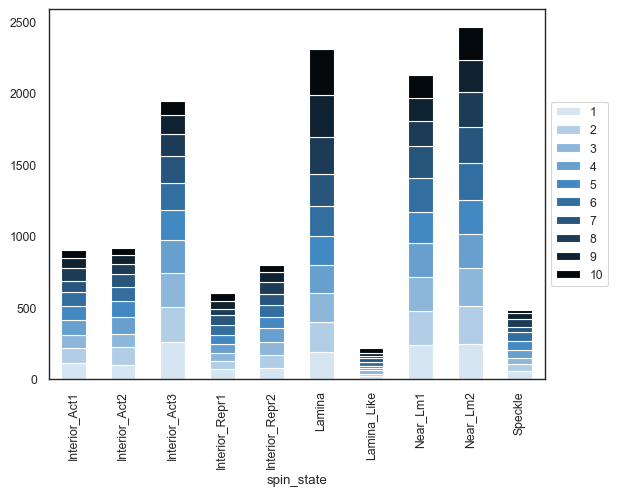

In [476]:
spin_sums_counts['count'].plot(kind='bar', stacked='True', color=blues)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

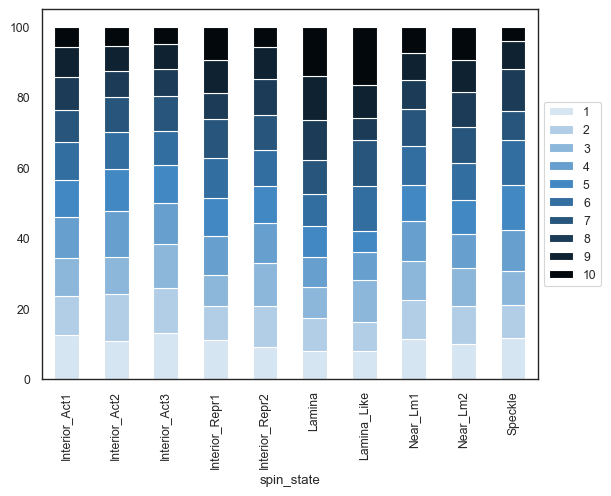

In [480]:
spin_counts_percent = spin_sums_counts['count'].copy()
cols = list(spin_sums_counts_percent['count'].columns)
spin_counts_percent[cols] = spin_counts_percent[cols].div(spin_counts_percent[cols].sum(axis=1), axis=0).multiply(100)
spin_counts_percent.plot(kind='bar', stacked='True', color=blues)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

#### x axis deciles

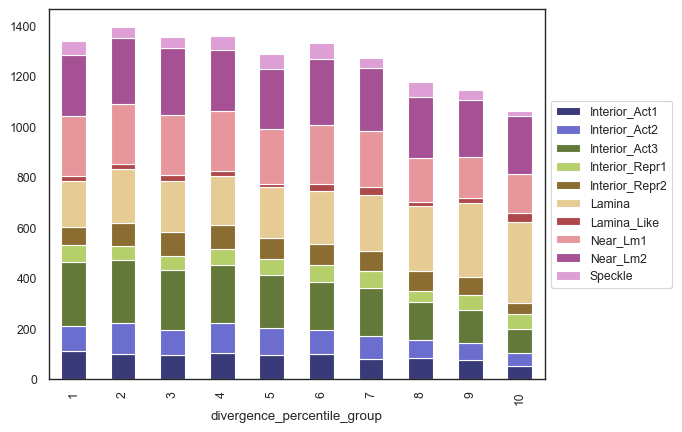

In [485]:
spin_counts_t_full = spin_sums_counts['count'].T
spin_counts_t_full.plot(kind='bar', stacked='True', cmap = 'tab20b')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [486]:
spin_counts_t = spin_sums_counts['count'].T
spin_counts_t['Interior Active'] = spin_counts_t.Interior_Act1 + spin_counts_t.Interior_Act2 + spin_counts_t.Interior_Act3
spin_counts_t['Interior Repressive'] = spin_counts_t.Interior_Repr1 + spin_counts_t.Interior_Repr2
spin_counts_t['Lamina/Lamina Like'] = spin_counts_t.Lamina + spin_counts_t.Lamina_Like
spin_counts_t['Near Lamina'] = spin_counts_t.Near_Lm1 + spin_counts_t.Near_Lm2
spin_counts_t = spin_counts_t.drop(columns=['Interior_Act1','Interior_Act2','Interior_Act3','Interior_Repr1','Interior_Repr2','Lamina','Lamina_Like','Near_Lm1','Near_Lm2'])

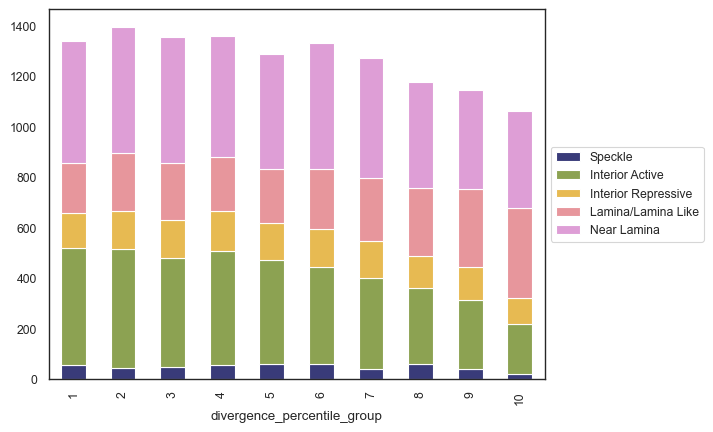

In [487]:
spin_counts_t.plot(kind='bar', stacked='True', cmap = 'tab20b')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

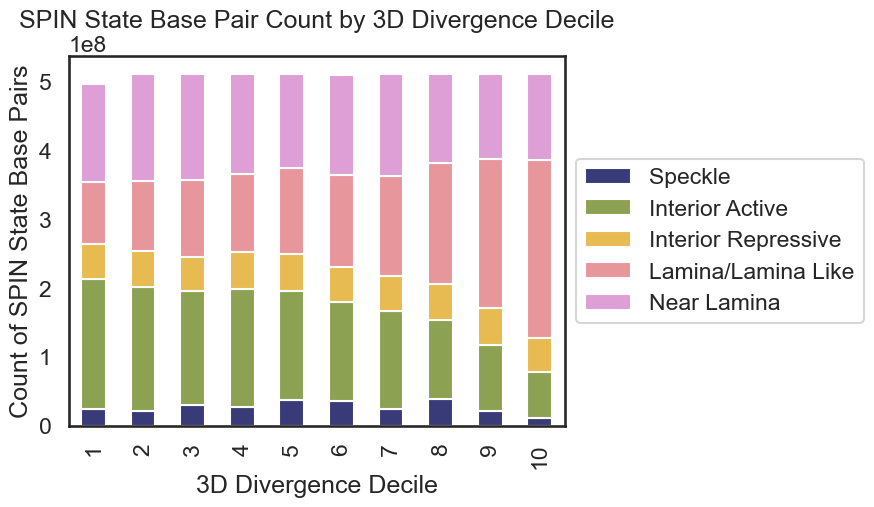

In [513]:
spin_sum_t.plot(kind='bar', stacked='True', cmap = 'tab20b')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('Count of SPIN State Base Pairs')
plt.xlabel('3D Divergence Decile')
plt.title('SPIN State Base Pair Count by 3D Divergence Decile')
plt.show()


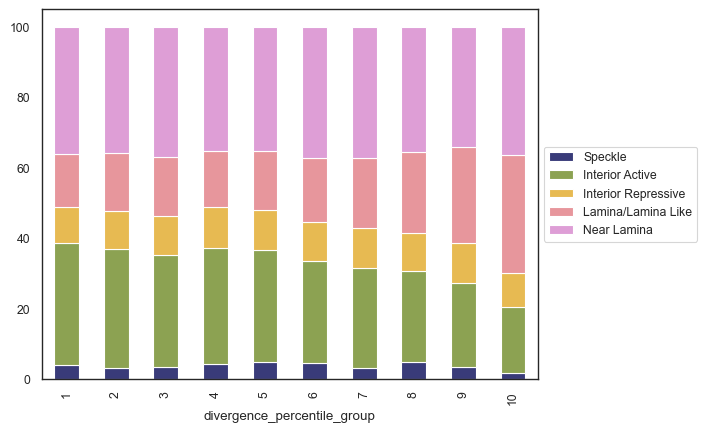

In [491]:
df1 = spin_counts_t.copy()
cols = list(df1.columns)
df1[cols] = df1[cols].div(df1[cols].sum(axis=1), axis=0).multiply(100)
df1.plot(kind='bar', stacked='True', cmap = 'tab20b')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

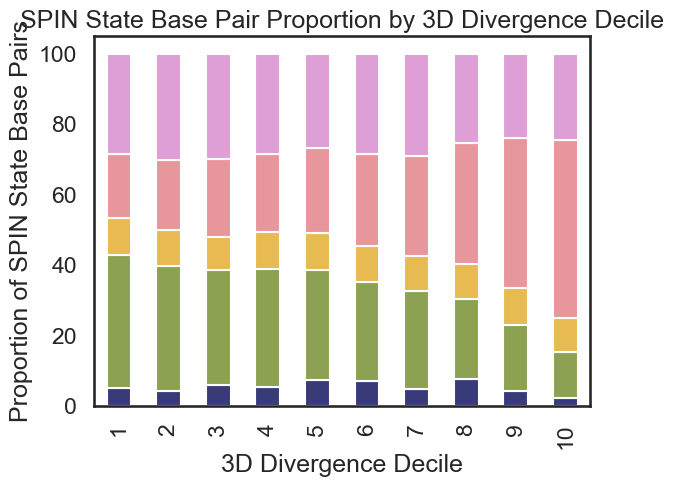

In [514]:
df1 = spin_sum_t.copy()
cols = list(df1.columns)
df1[cols] = df1[cols].div(df1[cols].sum(axis=1), axis=0).multiply(100)
df1.plot(kind='bar', stacked='True', cmap = 'tab20b')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('Proportion of SPIN State Base Pairs')
plt.xlabel('3D Divergence Decile')
plt.title('SPIN State Base Pair Proportion by 3D Divergence Decile')
plt.legend('',frameon=False)
plt.show()

# Characterize subset individuals

In [61]:
inds = pd.read_table('%s/intermediates/subset_inds.csv'%DATA_PATH, sep=',', index_col=0)

In [62]:
inds

0
0    AFR_GWD_female_HG02635
1    SAS_PJL_female_HG02725
2    EAS_CDX_female_HG01799
3    EAS_KHV_female_HG01874
4    EAS_CDX_female_HG01801
..                      ...
125  EAS_CHS_female_HG00531
126  SAS_PJL_female_HG02649
127  EUR_FIN_female_HG00373
128  AFR_GWD_female_HG02679
129  AFR_ACB_female_HG02505

[130 rows x 1 columns]

In [63]:
anc.loc[inds["0"]][anc.super_pop=='EAS']

/scratch/egilbertson/ipykernel_40157/3378879499.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anc.loc[inds["0"]][anc.super_pop=='EAS']


ancestor  genome_avg_mse  genome_avg_spearman  \
1KG                                                                             
EAS_CDX_female_HG01799  hsmrca_ancestral        0.000664             0.995682   
EAS_KHV_female_HG01874  hsmrca_ancestral        0.000653             0.995739   
EAS_CDX_female_HG01801  hsmrca_ancestral        0.000634             0.995784   
EAS_JPT_female_NA18998  hsmrca_ancestral        0.000691             0.995528   
EAS_CHS_female_HG00608  hsmrca_ancestral        0.000653             0.995581   
EAS_CDX_female_HG00864  hsmrca_ancestral        0.000624             0.995760   
EAS_CDX_female_HG01807  hsmrca_ancestral        0.000660             0.995622   
EAS_CDX_female_HG02188  hsmrca_ancestral        0.000655             0.995611   
EAS_CHB_female_NA18591  hsmrca_ancestral        0.000660             0.995761   
EAS_CHS_female_HG00584  hsmrca_ancestral        0.000633             0.995682   
EAS_KHV_female_HG02127  hsmrca_ancestral        0.000668             0.995438   
EAS_JPT_female_NA18951  hsmrca_ancestral        0.000656             0.995783   
EAS_CHB_female_NA18596  hsmrca_ancestral        0.000645             0.995833   
EAS_KHV_female_HG02069  hsmrca_ancestral        0.000663             0.995524   
EAS_JPT_female_NA18981  hsmrca_ancestral        0.000657             0.995541   
EAS_CHS_female_HG00566  hsmrca_ancestral        0.000702             0.995580   
EAS_CHB_female_NA18531  hsmrca_ancestral        0.000656             0.995737   
EAS_KHV_female_HG01869  hsmrca_ancestral        0.000642             0.995840   
EAS_CHB_female_NA18631  hsmrca_ancestral        0.000655             0.995708   
EAS_JPT_female_NA18991  hsmrca_ancestral        0.000628             0.995709   
EAS_KHV_female_HG02075  hsmrca_ancestral        0.000663             0.995656   
EAS_JPT_female_NA19084  hsmrca_ancestral        0.000618             0.995831   
EAS_CHB_female_NA18541  hsmrca_ancestral        0.000653             0.995668   
EAS_CHS_female_HG00596  hsmrca_ancestral        0.000686             0.995342   
EAS_CHS_female_HG00531  hsmrca_ancestral        0.000613             0.995891   

                       super_pop sub_pop     sex       id  divergence  \
1KG                                                                     
EAS_CDX_female_HG01799       EAS     CDX  female  HG01799    0.004318   
EAS_KHV_female_HG01874       EAS     KHV  female  HG01874    0.004261   
EAS_CDX_female_HG01801       EAS     CDX  female  HG01801    0.004216   
EAS_JPT_female_NA18998       EAS     JPT  female  NA18998    0.004472   
EAS_CHS_female_HG00608       EAS     CHS  female  HG00608    0.004419   
EAS_CDX_female_HG00864       EAS     CDX  female  HG00864    0.004240   
EAS_CDX_female_HG01807       EAS     CDX  female  HG01807    0.004378   
EAS_CDX_female_HG02188       EAS     CDX  female  HG02188    0.004389   
EAS_CHB_female_NA18591       EAS     CHB  female  NA18591    0.004239   
EAS_CHS_female_HG00584       EAS     CHS  female  HG00584    0.004318   
EAS_KHV_female_HG02127       EAS     KHV  female  HG02127    0.004562   
EAS_JPT_female_NA18951       EAS     JPT  female  NA18951    0.004217   
EAS_CHB_female_NA18596       EAS     CHB  female  NA18596    0.004167   
EAS_KHV_female_HG02069       EAS     KHV  female  HG02069    0.004476   
EAS_JPT_female_NA18981       EAS     JPT  female  NA18981    0.004459   
EAS_CHS_female_HG00566       EAS     CHS  female  HG00566    0.004420   
EAS_CHB_female_NA18531       EAS     CHB  female  NA18531    0.004263   
EAS_KHV_female_HG01869       EAS     KHV  female  HG01869    0.004160   
EAS_CHB_female_NA18631       EAS     CHB  female  NA18631    0.004292   
EAS_JPT_female_NA18991       EAS     JPT  female  NA18991    0.004291   
EAS_KHV_female_HG02075       EAS     KHV  female  HG02075    0.004344   
EAS_JPT_female_NA19084       EAS     JPT  female  NA19084    0.004169   
EAS_CHB_female_NA18541       EAS     CHB  female  NA18541    0.004332   
EAS_CHS_female_HG00

/scratch/egilbertson/ipykernel_40157/319631601.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(anc.loc[inds["0"]][anc.super_pop=='EAS'].divergence)


(array([2., 4., 4., 4., 3., 3., 3., 0., 1., 1.]),
 array([0.00410907, 0.00416394, 0.0042188 , 0.00427367, 0.00432854,
        0.00438341, 0.00443828, 0.00449314, 0.00454801, 0.00460288,
        0.00465775]),
 <BarContainer object of 10 artists>)

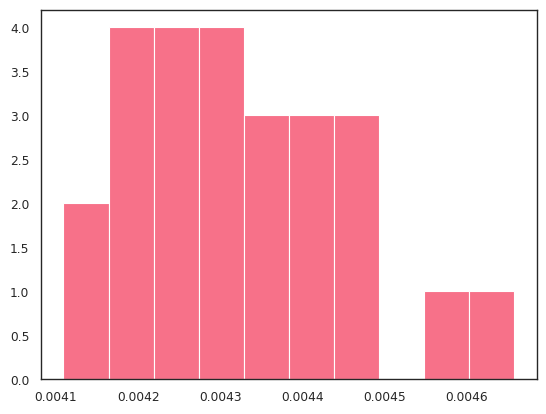

In [64]:
plt.hist(anc.loc[inds["0"]][anc.super_pop=='EAS'].divergence)

/scratch/egilbertson/ipykernel_40157/516970439.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(genome_wide_both.loc[inds["0"]][genome_wide_both.super_pop=='EAS'].seq_diff, color = (0.5061679352128585, 0.6675954483699535, 0.3024282922555064))


(array([1., 0., 0., 0., 0., 2., 5., 9., 5., 3.]),
 array([0.00147583, 0.00148052, 0.00148522, 0.00148991, 0.00149461,
        0.0014993 , 0.00150399, 0.00150869, 0.00151338, 0.00151808,
        0.00152277]),
 <BarContainer object of 10 artists>)

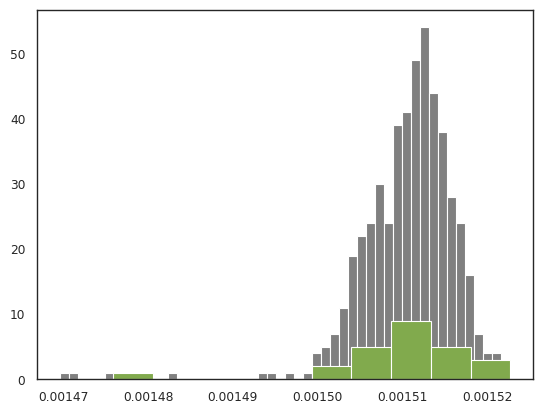

In [65]:

plt.hist(genome_wide_both[genome_wide_both.super_pop=='EAS'].seq_diff, color='grey', bins=50)
plt.hist(genome_wide_both.loc[inds["0"]][genome_wide_both.super_pop=='EAS'].seq_diff, color = (0.5061679352128585, 0.6675954483699535, 0.3024282922555064))

/scratch/egilbertson/ipykernel_40157/33395101.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(genome_wide_both.loc[inds["0"]][genome_wide_both.super_pop=='EAS'].divergence, color = (0.5061679352128585, 0.6675954483699535, 0.3024282922555064))


(array([2., 4., 4., 4., 3., 3., 3., 0., 1., 1.]),
 array([0.00410907, 0.00416394, 0.0042188 , 0.00427367, 0.00432854,
        0.00438341, 0.00443828, 0.00449314, 0.00454801, 0.00460288,
        0.00465775]),
 <BarContainer object of 10 artists>)

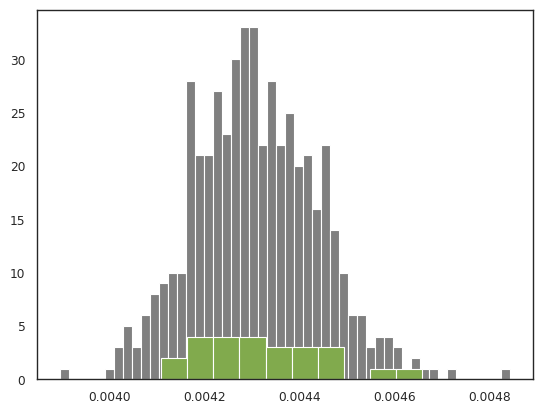

In [66]:

plt.hist(genome_wide_both[genome_wide_both.super_pop=='EAS'].divergence, color='grey', bins=50)
plt.hist(genome_wide_both.loc[inds["0"]][genome_wide_both.super_pop=='EAS'].divergence, color = (0.5061679352128585, 0.6675954483699535, 0.3024282922555064))